_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*Agnese Adorante, Hwajin Shin, Lucia Gonzalez Anton* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span> Yes we used Chatgpt

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [ ]:
# import packages here

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.cm as cm
import random
from scipy.signal import find_peaks
from scipy.stats import zscore
#from oasis.functions import deconvolve
import urllib.request
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
url = "https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py"
urllib.request.urlretrieve(url, "oopsi.py")
import oopsi
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label
from matplotlib.gridspec import GridSpec
from scipy.optimize import minimize
from functools import partial
from scipy.special import gammaln
from sklearn.linear_model import Lasso
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from rfest import splineLG, splineLNP, splineLNLN
from rfest import ALD, ASD, GLM, LNLN, LNP
from rfest.utils import build_design_matrix
from scipy.ndimage import center_of_mass
from scipy.stats import spearmanr
from skimage.measure import moments_central
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import pickle

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-07-19 18:47:42Hora de ver. Europa Occidental

Python implementation: CPython
Python version       : 3.9.23
IPython version      : 8.18.1

sklearn: 1.6.1

pandas    : 1.5.3
skimage   : 0.24.0
sklearn   : 1.6.1
scipy     : 1.10.1
rfest     : 2.1.2
numpy     : 1.23.5
matplotlib: 3.9.4
seaborn   : 0.13.2
tqdm      : 4.67.1

Watermark: 2.5.0



## Context

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.


The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


path = os.getcwd()
data = load_data(path)

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure on the location of the receptive fields?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of:
1. Pre-processing
2. Spike inference
3. Tuning function fitting
4. Statistical testing.

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

# Utils

In [3]:
def plot_trace_with_stimulus(
    trace,
    time,
    stim_epochs,
    start_time,
    duration,
    event_trace=None,
    fs=30,
    colormap="tab10",
    behavior=False,
):
    """
    Plots a single calcium trace with vertical background shading for each stimulus type.

    Parameters:
        trace (np.ndarray): dF/F trace of one neuron
        time (np.ndarray): time vector
        stim_epochs (pd.DataFrame): with columns ['stimulus', 'start', 'end']
        start_time (float): time to start plotting (in seconds)
        duration (float): duration to plot (in seconds)
        event_trace (np.ndarray): optional, e.g. deconvolved spikes
        fs (int): sampling rate
        colormap (str): name of matplotlib colormap
    """

    # Set time window
    start_frame = int(start_time * fs)
    end_frame = int((start_time + duration) * fs)
    time_window = time[start_frame:end_frame]
    trace_window = trace[start_frame:end_frame]
    if event_trace is not None:
        event_window = event_trace[start_frame:end_frame]

    # Create stimulus colormap
    stim_types = sorted(stim_epochs["stimulus"].unique())
    colors = cm.get_cmap(colormap, len(stim_types))
    stim_color_map = {stim: colors(i) for i, stim in enumerate(stim_types)}

    # Plot
    plt.figure(figsize=(15, 4))

    # Background shading
    for _, row in stim_epochs.iterrows():
        stim_start, stim_end = row["start"], row["end"]
        stim_label = row["stimulus"]
        if (stim_end / fs) < start_time or (stim_start / fs) > (start_time + duration):
            continue  # outside window

        # Clamp shading to plotting window
        plot_start = max(stim_start / fs, start_time)
        plot_end = min(stim_end / fs, start_time + duration)

        plt.axvspan(plot_start, plot_end, color=stim_color_map[stim_label], alpha=0.2)

    # Plot traces
    plt.plot(
        time_window,
        trace_window / trace_window.max(),
        label="dff trace",
        color="steelblue",
    )
    if event_trace is not None:
        plt.plot(time_window, event_window, label="events trace", color="orange")

    if behavior is True:
        plt.plot(
            time_window,
            running_speed[0, start_frame:end_frame]
            / running_speed[0, start_frame:end_frame].max(),
            label="running speed",
            color="green",
        )
    # Legend for stimulus types
    legend_patches = [
        mpatches.Patch(color=stim_color_map[stim], label=stim) for stim in stim_types
    ]
    event_patchs = [plt.Line2D([], [], color="steelblue", label="dff trace")]
    if event_trace is not None:
        event_patchs.append(plt.Line2D([], [], color="orange", label="events trace"))
    if behavior is True:
        event_patchs.append(plt.Line2D([], [], color="green", label="running speed"))
    plt.legend(handles=legend_patches + event_patchs)

    plt.xlabel("Time (s)")
    plt.ylabel("Normalized response magnitude")
    plt.title(f"Calcium Trace with Stimulus Background")
    plt.tight_layout()
    plt.show()

In [4]:
def plot_calcium_traces(indices, start_time, duration, fs=30, offset=3):
    """
    Plot calcium traces for selected neuron indices within a time window.

    Parameters:
        indices (list): List of neuron indices to plot
        start_time (float): Start time in seconds
        duration (float): Duration in seconds
        fs (int): Sampling rate (frames per second)
        offset (float): Vertical offset between traces
        time (np.ndarray): Time vector
        traces (np.ndarray): Calcium trace array (neurons x time)
    """
    time = data["t"]
    traces = data["dff"]

    # Convert time window to frame indices
    start_frame = int(start_time * fs)
    end_frame = int((start_time + duration) * fs)

    # Extract time and trace segments
    time_window = time[start_frame:end_frame]
    trace_window = traces[:, start_frame:end_frame]

    # Plot
    plt.figure(figsize=(12, 6))
    for i, neuron_idx in enumerate(indices):
        trace = trace_window[neuron_idx]
        trace_norm = trace / trace.max()  # normalize
        plt.plot(time_window, trace_norm + i * offset, color="black")

    plt.title(f"Normalized Calcium Traces")
    plt.xlabel("Time (s)")
    plt.yticks(np.arange(len(indices)) * offset, indices)
    plt.ylabel("Neuron ID")
    plt.tight_layout()
    plt.show()

In [5]:
def plot_detected_spikes(trace, spike_idxs, fs, neuron_id="neuron_id", window=None):
    """
    Plot the calcium trace with detected spikes shown as red crosses.

    Parameters:
        trace: 1D np.array, calcium trace of one neuron
        spike_idxs: list or np.array of spike indices
        fs: sampling rate in Hz
        neuron_id: int or str, for labeling
        window: tuple (start_time, end_time) in seconds (optional)
    """
    trace = np.asarray(trace)
    spike_idxs = np.asarray(spike_idxs, dtype=int)
    t = np.arange(len(trace)) / fs

    if window:
        start_time, end_time = window
        idx_start = int(start_time * fs)
        idx_end = int(end_time * fs)
        t = t[idx_start:idx_end]
        trace = trace[idx_start:idx_end]

        # Only include spikes within the window
        spike_idxs = spike_idxs[(spike_idxs >= idx_start) & (spike_idxs < idx_end)]
        spike_idxs_windowed = spike_idxs - idx_start
    else:
        spike_idxs_windowed = spike_idxs

    # Safety check: ensure all spike indices are within range
    spike_idxs_windowed = spike_idxs_windowed[
        (spike_idxs_windowed >= 0) & (spike_idxs_windowed < len(trace))
    ]

    plt.figure(figsize=(12, 4))
    plt.plot(t, trace, label="Calcium Trace")
    plt.scatter(
        t[spike_idxs_windowed],
        trace[spike_idxs_windowed],
        color="red",
        marker="x",
        label="Detected Spikes",
        zorder=3,
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Fluorescence")
    plt.title(f"Neuron {neuron_id} - Detected Spikes")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def plot_population_firing_rate(
    spike_traces, bin_size=30, sampling_rate=30, threshold=0.5, figsize=(8, 4)
):
    """
    Plots average population firing rate over time.

    Parameters:
    - spike_traces: array of shape (n_neurons, n_frames)
    - bin_size: number of frames per bin (e.g. 30 = 1 sec @ 30 Hz)
    - sampling_rate: imaging rate
    - threshold: spike detection threshold
    """
    n_neurons, n_frames = spike_traces.shape
    spike_binary = spike_traces > threshold
    n_bins = n_frames // bin_size
    pop_rate = []

    for i in range(n_bins):
        bin_slice = slice(i * bin_size, (i + 1) * bin_size)
        rate = spike_binary[:, bin_slice].sum() / (
            n_neurons * (bin_size / sampling_rate)
        )  # spikes/s/neuron
        pop_rate.append(rate)

    time_bins = np.arange(n_bins) * (bin_size / sampling_rate)

    plt.figure(figsize=figsize)
    plt.plot(time_bins, pop_rate, color="dodgerblue")
    plt.xlabel("Time (s)")
    plt.ylabel("Avg Firing Rate (Hz)")
    plt.title("Population Firing Rate Over Time")
    plt.tight_layout()
    plt.show()

In [7]:
def plot_raster_with_stimulus(
    spike_traces,
    stim_epochs,
    stim_metadata,
    stimulus_name="locally_sparse_noise",
    threshold=0.5,
    sampling_rate=30,
    figsize=(12, 6),
    title="Raster Plot with Stimulus",
):
    """
    Raster plot with a separate subplot on top for stimulus timing.
    """
    n_neurons, n_frames = spike_traces.shape
    times = np.arange(n_frames) / sampling_rate

    # --- Build stimulus mask
    stim_mask = np.zeros(n_frames, dtype=bool)
    for _, epoch in stim_epochs[stim_epochs["stimulus"] == stimulus_name].iterrows():
        stim_start, stim_end = epoch["start"], epoch["end"]
        frame_indices = stim_metadata[
            (stim_metadata["start"] >= stim_start) & (stim_metadata["end"] <= stim_end)
        ][["start", "end"]].values
        for start, end in frame_indices:
            stim_mask[start:end] = True

    # --- Create two subplots
    fig, (ax_stim, ax_raster) = plt.subplots(
        2,
        1,
        figsize=figsize,
        height_ratios=[0.3, 1],
        sharex=True,
        gridspec_kw={"hspace": 0.05},
    )

    fig.suptitle(title, fontsize=14)

    # --- Plot stimulus bar (top subplot)
    stim_on_times = np.where(stim_mask)[0]
    if len(stim_on_times) > 0:
        diffs = np.diff(stim_on_times)
        split_idx = np.where(diffs > 1)[0] + 1
        chunks = np.split(stim_on_times, split_idx)
        for chunk in chunks:
            t_start = chunk[0] / sampling_rate
            t_end = chunk[-1] / sampling_rate
            ax_stim.axvspan(
                t_start,
                t_end,
                color="orange",
                alpha=0.7,
                lw=0,
            )
    ax_stim.set_yticks([])
    ax_stim.set_ylabel("Stim")
    ax_stim.set_xlim(times[0], times[-1])
    ax_stim.spines["top"].set_visible(False)
    ax_stim.spines["right"].set_visible(False)
    ax_stim.spines["left"].set_visible(False)

    # --- Plot raster (bottom subplot)
    for neuron_id in range(n_neurons):
        spikes = np.where(spike_traces[neuron_id] > threshold)[0]
        ax_raster.vlines(
            times[spikes],
            neuron_id + 0.5,
            neuron_id + 1.5,
            color="black",
            linewidth=0.5,
        )

    ax_raster.set_ylim(0.5, n_neurons + 0.5)
    ax_raster.set_xlabel("Time (s)")
    ax_raster.set_ylabel("Neuron ID")

    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Exploratory Data Analysis

First, we explore the dataset. Here's what we will look at:
- the calcium trace
- the stim_epochs and stim_metadata: the two dataframes containing information about presented stimuli
- stims array containing all the presented stimuli
- roi masks and max projection to identify the position of the neurons on the cortical surface as well as their depth??
- running speed of the animal, likely won't be very important in out analysis but in this exploratory stage we're itnerested in seeing how the running speed differs with presented stimuli and wether it's correlated with neural activity

In [8]:
# Clacium trace
traces = data["dff"]  # shape: (n_cells, n_frames)

# Stimuli
stim_epochs = data["stim_epoch_table"]
stim_epochs.columns = ["stimulus", "start", "end"]
stim_metadata = data["stim_table"]
stims = data["stim"]

# Roi masks and projections
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]

# Behavior
running_speed = data["running_speed"]

# time
time = data["t"]

In [9]:
print("Traces Info")
print(f"Number of cells: {traces.shape[0]}")
print(f"Number of frames: {traces.shape[1]}")
print("---------------------------------------------------")
print("Stimulus Info")
print(f"Number of stimulus epochs: {len(stim_epochs)}")
print(f"Stimuli types: {set(stim_epochs['stimulus'])}")
print(f"Number of presented stimuli: {stim_metadata.shape[0]}")
print(f"Stimulus shape: {stims.shape[1], stims.shape[2]}")
print("---------------------------------------------------")
print("Recording Frequency")
dt = np.median(np.diff(time))  # sampling interval in seconds
fs = 1 / dt  # sampling frequency in Hz
print(f"Time resolution: {np.round(fs)} Hz")
print("---------------------------------------------------")
print("ROI Masks Info")
print(f"Max projection shape: {max_projection.shape}")
print(f"Number of ROIs: {roi_masks.shape[0]}")

Traces Info
Number of cells: 189
Number of frames: 105968
---------------------------------------------------
Stimulus Info
Number of stimulus epochs: 7
Stimuli types: {'natural_movie_one', 'natural_movie_two', 'locally_sparse_noise', 'spontaneous'}
Number of presented stimuli: 8880
Stimulus shape: (16, 28)
---------------------------------------------------
Recording Frequency
Time resolution: 30.0 Hz
---------------------------------------------------
ROI Masks Info
Max projection shape: (512, 512)
Number of ROIs: 189


This is already informative. We have 189 neurons recorded for 105968 frames at a time resolution of 30 Hz, meaning that the neurons were recorder for a totall of .. seconds.
4 types of stimuli were presented in the course of the experiment but we're only interested in locally_sparse_noise. Each has shape 16,28 and the total of stimuli presented is 8880.
The ROI masks are of shape (512,512) and we have one mask for each neuron.

## Calcium Trace

Now we plot the calcium trace for all neurons

Text(0, 0.5, 'Neurons')

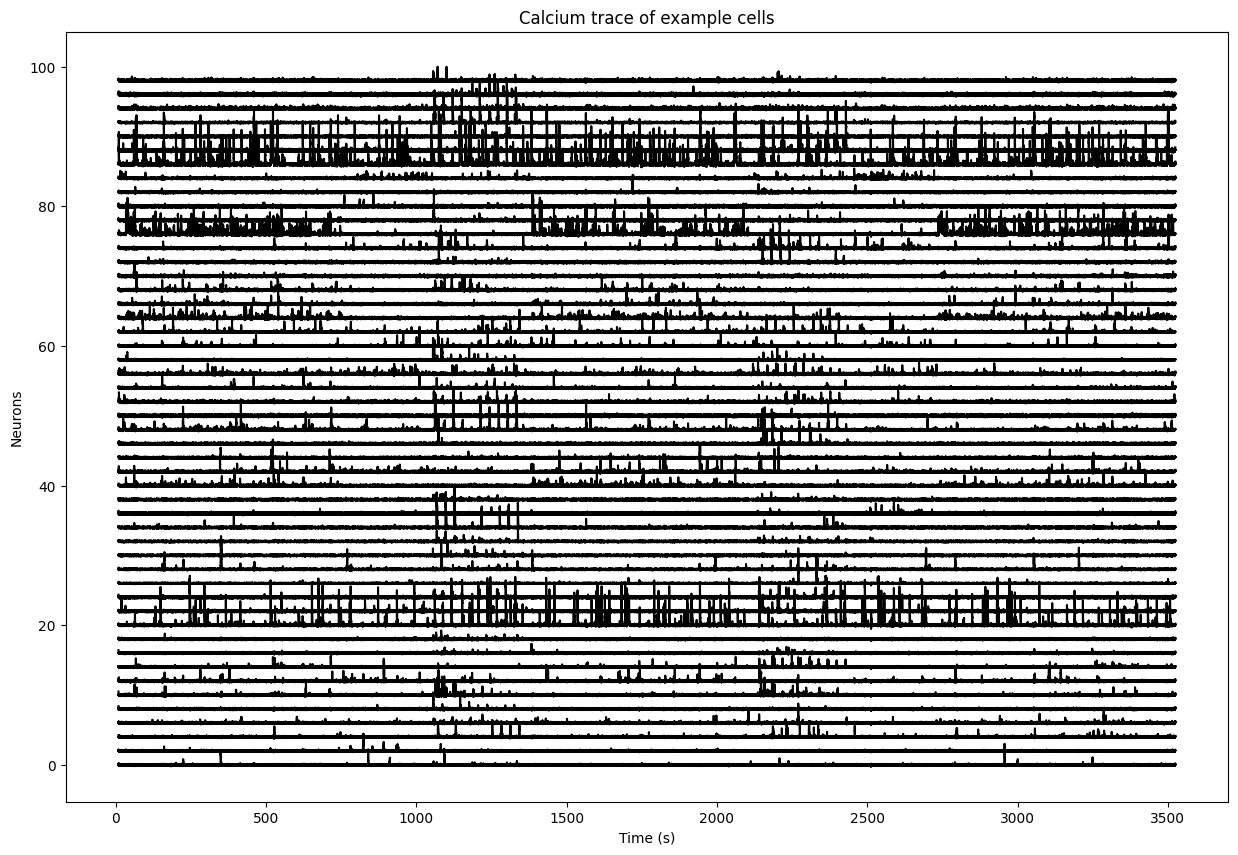

In [10]:
fig = plt.figure(figsize=(15, 10))
for i in range(50):
    plt.plot(time, traces[i, :] + (i * 2), color="black")
plt.title("Calcium trace of example cells")
plt.xlabel("Time (s)")
plt.ylabel("Neurons")

It's evident that some neurons are more active than others, some have noiser activity with high frequencies and some have more localized acitivty with peaks, but it's hard to say more than this from looking at calcium trace only, the spikes extraction and furthwer analysis of the results of that will help us in this task to describe more accurately neural activity


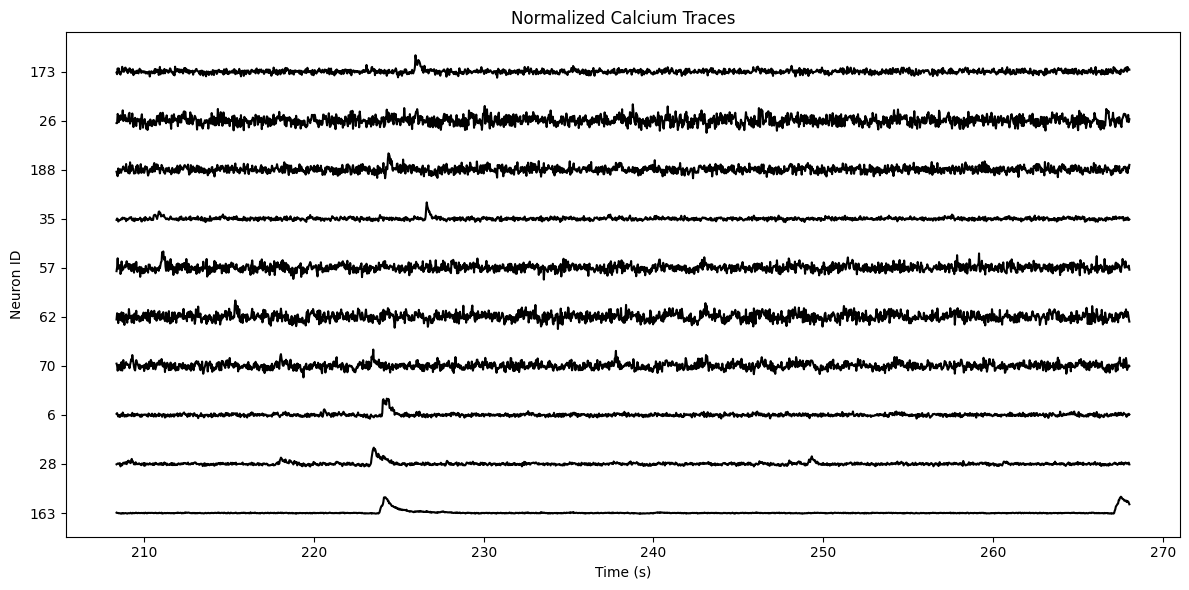

In [11]:
random.seed(42)
indices = random.sample(range(traces.shape[0]), 10)

plot_calcium_traces(indices, start_time=200, duration=60)

C:\Users\34600\AppData\Local\Temp\ipykernel_31220\4122868606.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


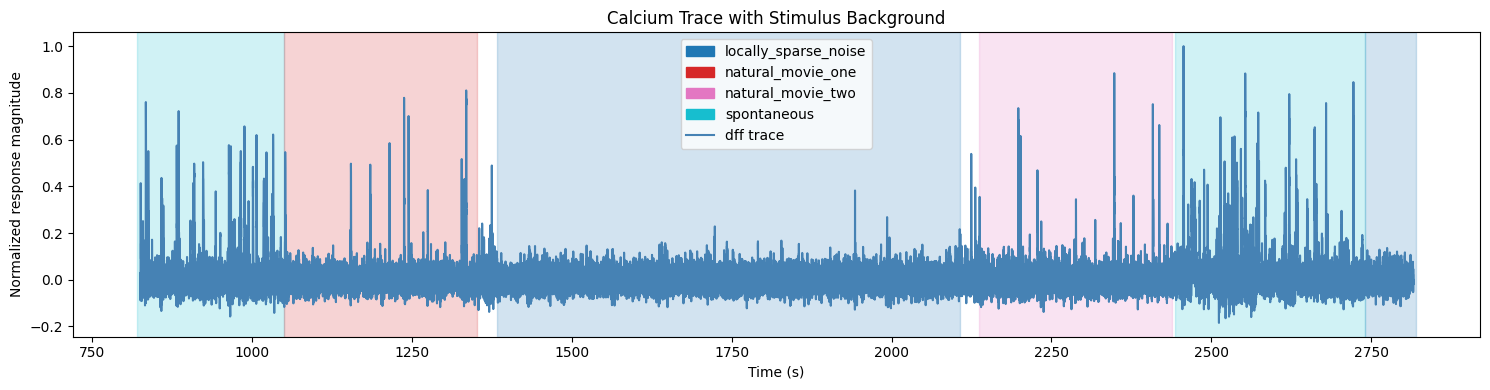

In [12]:
# Choose neuron index and time window
neuron_idx = 42
start_time = 820
duration = 2000

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration)

It's clear from here that the most exciting stimuli are netural movies as well as spontaneous periods. Locally sparse noise instead does not drive very high activity.

C:\Users\34600\AppData\Local\Temp\ipykernel_31220\4122868606.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


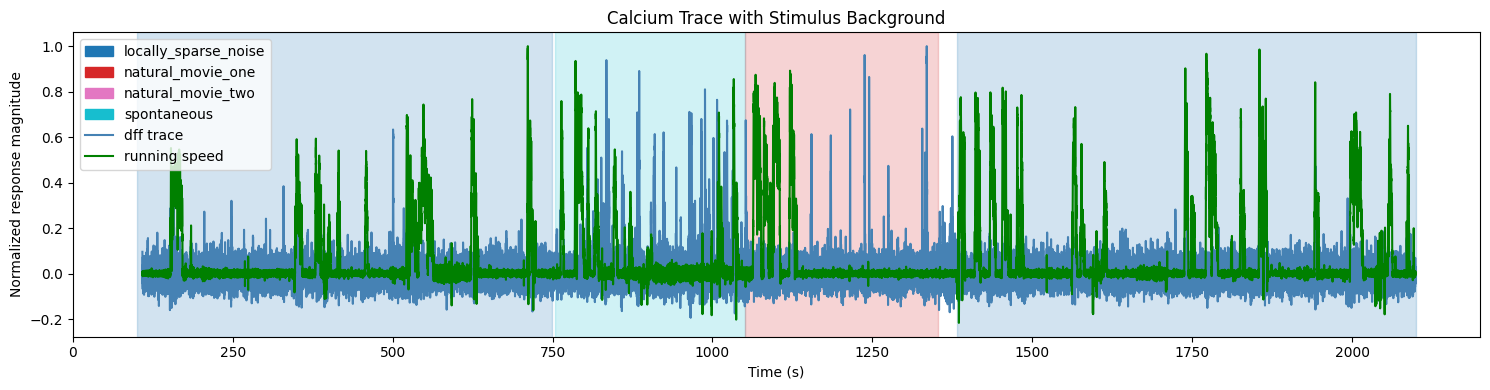

In [13]:
neuron_idx = 42
start_time = 100
duration = 2000

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration, behavior=True)

C:\Users\34600\AppData\Local\Temp\ipykernel_31220\4122868606.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


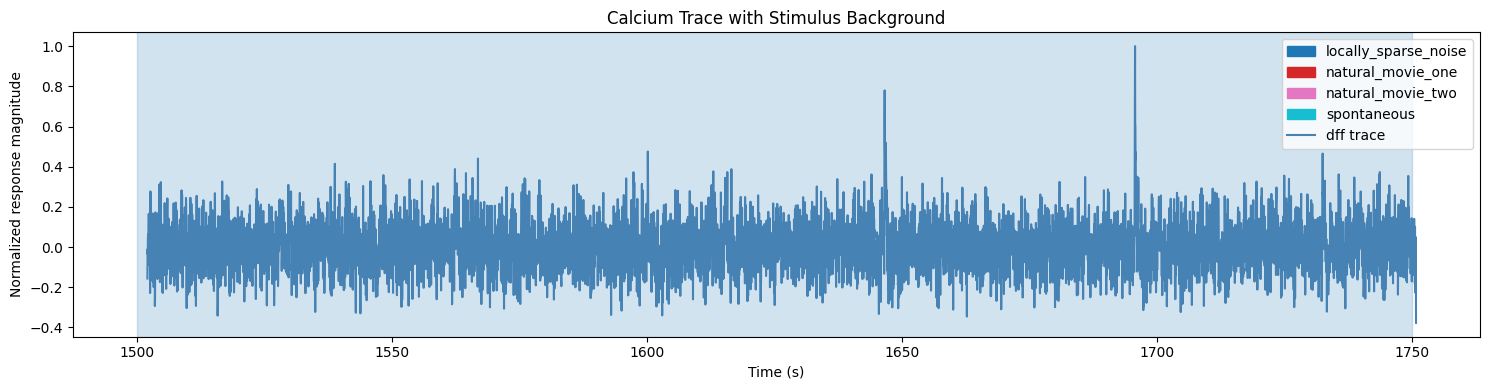

In [14]:
neuron_idx = 11
start_time = 1500
duration = 250

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration)

## Stimulus

From Alleninstitute website:

**Locally Sparse Noise**

The locally sparse noise stimulus consists of black and white spots flashed on the monitor. For each frame of the stimulus a small number of pixels were white and a small number were black, while the rest were mean luminance gray. The white and black spots were distributed such that no two spots were within 5 pixels of each other. Each time a given pixel was occupied by a black (or white) spot, there was a different array of other pixels occupied by either black or white spots. As a result, when all of the frames when that pixel was occupied by the black spot were averaged together, there was no significant structure surrounding the specified pixel. Further, the stimulus was well balanced with regards to the contrast of the pixels, such that while there was a slightly higher probability of a pixel being occupied just outside of the 5-pixel exclusion zone, the probability was equal for pixels of both contrast. Each pixel was occupied by either a white or black spot a variable number of times. Typically, each frame we presented for 0.25 seconds and followed immediately by the next trial without any intertrial interval. There are no blanksweeps.

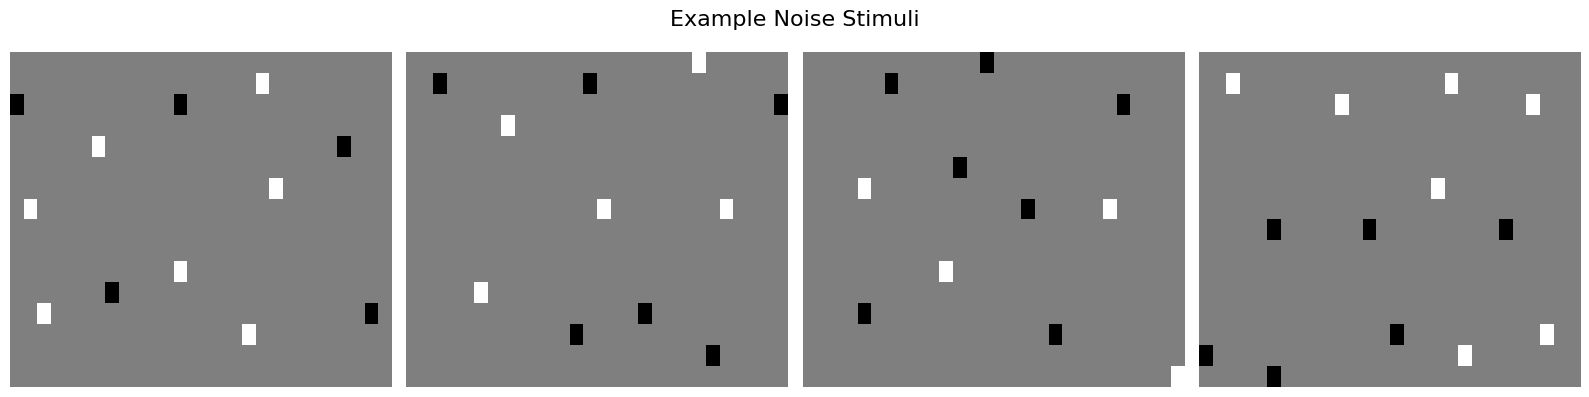

In [15]:
# Filter stim_epochs for only locally_sparse_noise
lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]

# Get all frames within those epochs
lsn_frame_idxs = []
for _, row in lsn_epochs.iterrows():
    start, end = row["start"], row["end"]
    matching_frames = stim_metadata[
        (stim_metadata["start"] >= start) & (stim_metadata["end"] <= end)
    ]
    lsn_frame_idxs.extend(matching_frames["frame"].values)

lsn_frame_idxs = np.array(lsn_frame_idxs)
n = len(lsn_frame_idxs)

# Pick 4 evenly spaced frame indices
example_indices = np.linspace(0, n - 1, 4, dtype=int)
example_frames = [stims[lsn_frame_idxs[i]] for i in example_indices]

# Plot them
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axs[i].imshow(example_frames[i], cmap="grey", aspect="auto")
    axs[i].axis("off")

plt.suptitle("Example Noise Stimuli", fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
np.unique(stims[0])

array([  0, 127, 255], dtype=uint8)

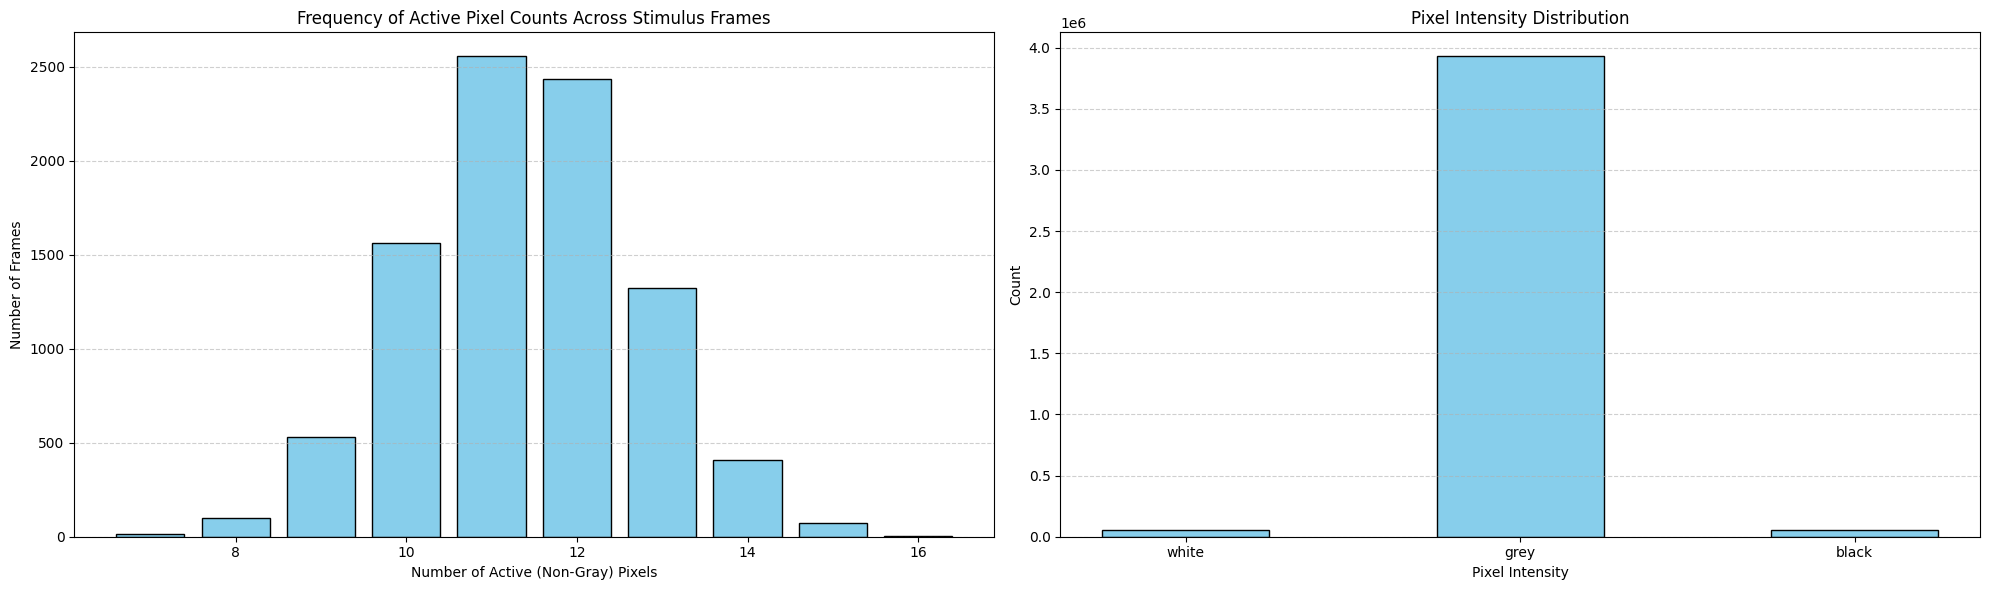

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Subplot 1: Frequency of Active Pixel Counts (Bar Plot)
gray_value = 127
non_gray_counts = np.sum(stims != gray_value, axis=(1, 2))
unique_counts, counts_frequency = np.unique(non_gray_counts, return_counts=True)

axs[0].bar(unique_counts, counts_frequency, color="skyblue", edgecolor="black")
axs[0].set_title("Frequency of Active Pixel Counts Across Stimulus Frames")
axs[0].set_xlabel("Number of Active (Non-Gray) Pixels")
axs[0].set_ylabel("Number of Frames")
axs[0].grid(axis="y", linestyle="--", alpha=0.6)

# Subplot 2: Pixel Intensity Distribution (Only 0, 127, 255)
intensity_labels = ["white", "grey", "black"]
intensity_values = [0, 127, 255]
intensity_counts = [np.sum(stims == val) for val in intensity_values]

axs[1].bar(
    [str(i) for i in intensity_labels],
    intensity_counts,
    color="skyblue",
    edgecolor="black",
    width=0.5,
)
axs[1].set_title("Pixel Intensity Distribution")
axs[1].set_xlabel("Pixel Intensity")
axs[1].set_ylabel("Count")
axs[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

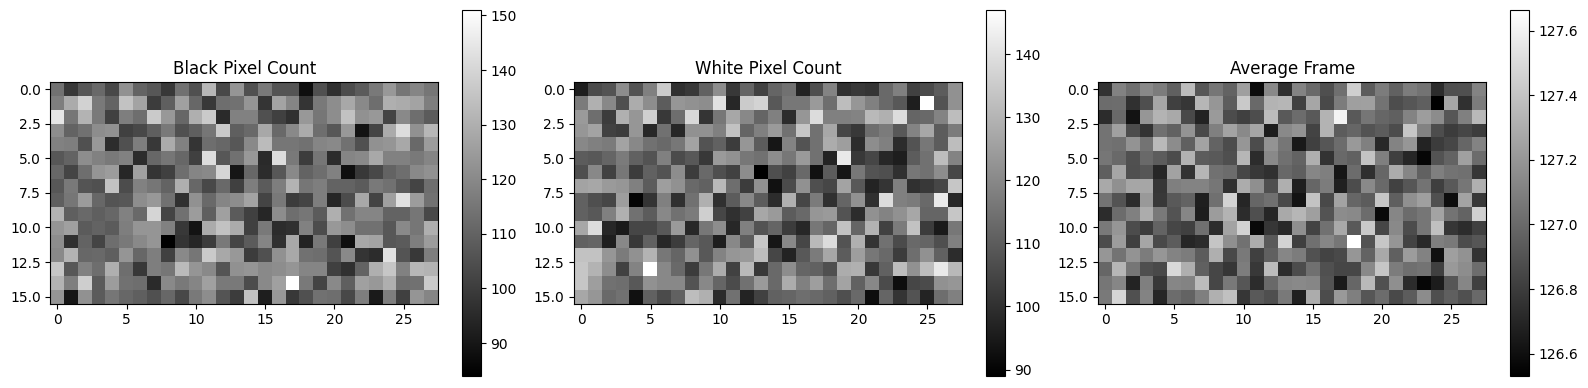

In [18]:
black_count = np.sum(stims == 0, axis=0)
white_count = np.sum(stims == 255, axis=0)
avg_frame = np.mean(stims, axis=0)

plt.figure(figsize=(16, 4))  # Adjust figure size for 1 row, 3 columns

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
plt.imshow(black_count, cmap="gray")
plt.title("Black Pixel Count")
plt.colorbar()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
plt.imshow(white_count, cmap="gray")
plt.title("White Pixel Count")
plt.colorbar()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
plt.imshow(avg_frame, cmap="gray")
plt.title("Average Frame")
plt.colorbar()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## ROi and max proj

(-0.5, 511.5, 511.5, -0.5)

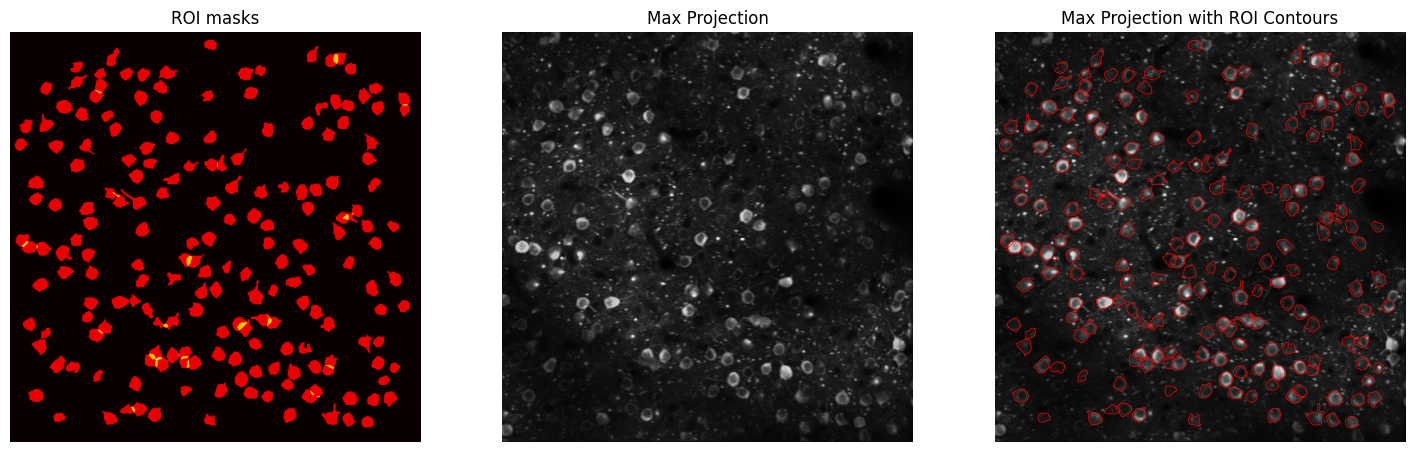

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
# roi masks: all of the segmented masks for cell bodies in this experiment.
ax[0].imshow(roi_masks.sum(axis=0), cmap="hot")
ax[0].set_title("ROI masks")
ax[0].axis("off")
# max projection: the projection of the full motion corrected movie for all of the cells imaged during the session.
ax[1].imshow(max_projection, cmap="grey")
ax[1].set_title("Max Projection")
ax[1].axis("off")
# max projection with ROI
ax[2].imshow(max_projection, cmap="gray")
ax[2].set_title("Max Projection with ROI Contours")
for roi in roi_masks:
    ax[2].contour(roi, levels=[0.5], colors="r", linewidths=0.5)
ax[2].axis("off")

In [20]:
max_projection.shape

(512, 512)

(-0.5, 24.5, 24.5, -0.5)

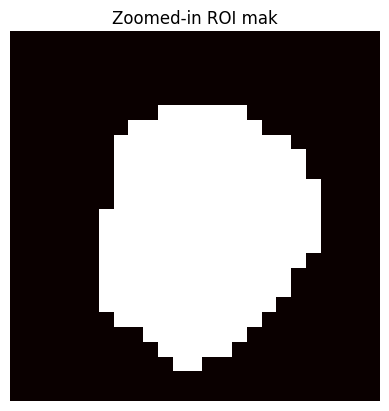

In [21]:
plt.imshow(roi_masks[0, 55:80, 100:125], cmap="hot")
plt.title("Zoomed-in ROI mak")
plt.axis("off")

## Pre-processing

In this preprocessing step, we applied a low-pass Butterworth filter followed by z-score normalization to the raw calcium fluorescence traces. The low-pass filter (3rd order, cutoff frequency = 0.7 Hz) was used to remove high-frequency noise while preserving the slower dynamics of neural activity relevant to calcium imaging. Filtering was implemented using zero-phase forward and reverse filtering (`filtfilt`) to avoid phase distortion. After filtering, each neuron's trace was normalized using z-scoring, ensuring that all neurons contributed equally in scale to downstream analyses. This combination of smoothing and normalization enhances signal quality and comparability across neurons, which is critical for consistent receptive field estimation and model fitting.

In [22]:
# cutoff and fs and order can be manipulated
def lowpass_filter(trace, cutoff=0.7, fs=fs, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    filtered_trace = np.zeros_like(trace)
    b, a = signal.butter(order, norm_cutoff, btype="low", analog=False)
    neuron = signal.filtfilt(b, a, trace)
    return neuron


filtered_trace = lowpass_filter(traces)
normalized_trace = zscore(filtered_trace, axis=1)

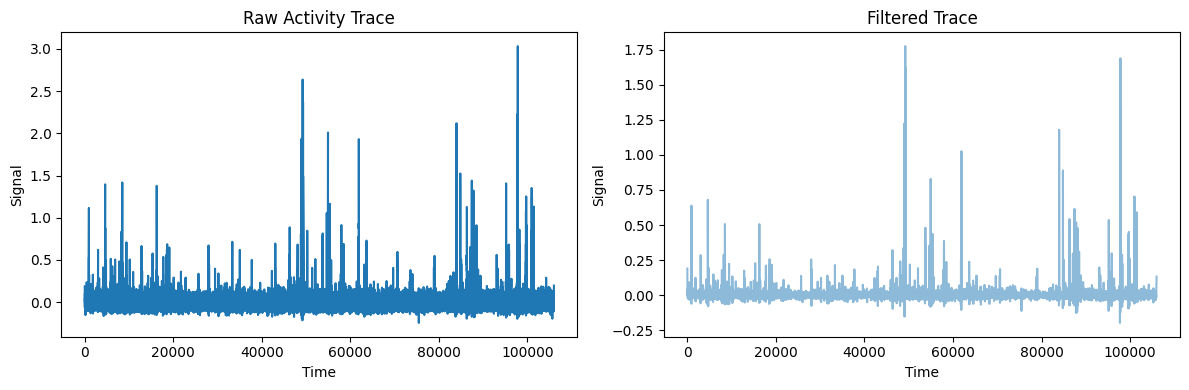

In [23]:
# Plot raw vs filtered trace
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot filtered trace
axs[0].plot(traces[100, :])
axs[0].set_title("Raw Activity Trace")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Signal")

# Plot raw activity trace
axs[1].plot(filtered_trace[100, :], alpha=0.5)
axs[1].set_title("Filtered Trace")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Signal")

# Adjust layout
plt.tight_layout()
plt.show()

## Events Extraction (Spike extraction)

To extract neural spiking events from calcium fluorescence signals, we employed three complementary spike inference approaches to ensure robustness and reliability in event detection.

1. **Simple spike thresholding** by using `scipy.signal.find_peaks`, a peak-finding algorithm that identifies local maxima in the calcium trace. This method provides a fast and intuitive way to detect large transients that likely correspond to neural firing, though it may miss smaller or overlapping events.

2. **OOPSI (Online Optimal Per Spike Inference)**, a probabilistic model-based method that estimates spike rates from calcium signals by explicitly modeling the underlying biophysical process of calcium dynamics. OOPSI assumes a generative model of calcium influx and exponential decay following neural spiking and uses Bayesian inference to estimate the most probable spike train. We used the implementation provided in the [`py-oopsi`](https://github.com/jovo/oopsi) package, which is a Python port of the original MATLAB algorithm introduced by Vogelstein et al. (2010).

3. **OASIS (Online Active Set method to Infer Spikes)**, a widely adopted and efficient deconvolution-based approach for spike inference. OASIS models the calcium trace as the convolution of a sparse spike train with a calcium response kernel and solves a constrained optimization problem to infer the most likely spike timings. Its fast, online implementation makes it well-suited for large-scale neural recordings. We used the `deconvolve` function from the [`oasis`](https://github.com/j-friedrich/OASIS) Python library, as described in Friedrich et al. (2017).

By combining these three methods—simple thresholding, Bayesian inference (OOPSI), and sparse deconvolution (OASIS)—we aimed to balance interpretability, accuracy, and computational efficiency in spike extraction. This multi-method approach provided complementary perspectives on spike timing and ensured the robustness of subsequent analyses.

## 1. Simple spike thresholding

In [24]:
def detect_spikes_single_neuron(
    trace: np.ndarray, fs: float, N: int = "N", lockout: float = 0.25
):
    """
    Detect spikes in a single calcium trace using thresholding and a lockout window.

    Returns:
        spike_idxs: Indices of detected spikes
        spike_trace: 1D float array with 1s at spike times, 0s elsewhere
    """
    threshold = N
    min_distance = max(1, int(lockout * fs))
    spike_idxs, _ = find_peaks(trace, height=threshold, distance=min_distance)
    spike_trace = np.zeros_like(trace, dtype=float)
    spike_trace[spike_idxs] = 1.0  # Impulse at spike time
    return spike_trace


def run_detect_spikes_all_neurons(data, fs=fs, N="N", lockout=0.25):
    """
    Apply spike detection to all neurons and return a 2D spike matrix (float).
    """
    n_neurons, n_timepoints = data.shape
    threshold_spikes = np.zeros((n_neurons, n_timepoints), dtype=float)

    for neuron_id in range(n_neurons):
        spike_trace = detect_spikes_single_neuron(
            data[neuron_id], fs=fs, N=N, lockout=lockout
        )
        threshold_spikes[neuron_id] = spike_trace

    return threshold_spikes

In [25]:
def plot_detected_spikes(trace, spike_idxs, fs, neuron_id="neuron_id", window=None):
    """
    Plot the calcium trace with detected spikes shown as red crosses.

    Parameters:
        trace: 1D np.array, calcium trace of one neuron
        spike_idxs: list or np.array of spike indices
        fs: sampling rate in Hz
        neuron_id: int or str, for labeling
        window: tuple (start_time, end_time) in seconds (optional)
    """
    trace = np.asarray(trace)
    spike_idxs = np.asarray(spike_idxs, dtype=int)
    t = np.arange(len(trace)) / fs

    if window:
        start_time, end_time = window
        idx_start = int(start_time * fs)
        idx_end = int(end_time * fs)
        t = t[idx_start:idx_end]
        trace = trace[idx_start:idx_end]

        # Only include spikes within the window
        spike_idxs = spike_idxs[(spike_idxs >= idx_start) & (spike_idxs < idx_end)]
        spike_idxs_windowed = spike_idxs - idx_start
    else:
        spike_idxs_windowed = spike_idxs

    # Safety check: ensure all spike indices are within range
    spike_idxs_windowed = spike_idxs_windowed[
        (spike_idxs_windowed >= 0) & (spike_idxs_windowed < len(trace))
    ]

    plt.figure(figsize=(12, 4))
    plt.plot(t, trace, label="Calcium Trace")
    plt.scatter(
        t[spike_idxs_windowed],
        trace[spike_idxs_windowed],
        color="red",
        marker="x",
        label="Detected Spikes",
        zorder=3,
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Fluorescence")
    plt.title(f"Neuron {neuron_id} - Detected Spikes by Thresholding")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
# Threshold for spike detection
N = 2

# Run threshold-based spike inference
threshold_spikes = run_detect_spikes_all_neurons(
    normalized_trace, fs=fs, N=N, lockout=0.25
)

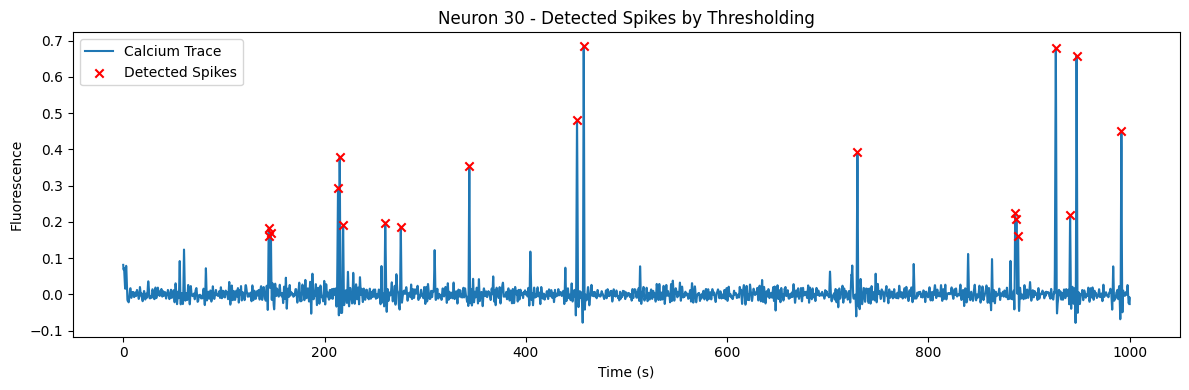

In [27]:
neuron_id = 30
trace = filtered_trace[neuron_id]  # calcium trace
spike_trace = threshold_spikes[neuron_id]  # binary spike train

# Extract spike indices where spike_trace == 1
spike_idxs = np.where(spike_trace == 1)[0]

# Plot
plot_detected_spikes(trace, spike_idxs, fs=fs, neuron_id=neuron_id, window=(0, 1000))

## 2. Spike Extraction with OOPSIE

In [28]:
# Load OOPSI results for all neurons previously calculated

oopsi_result = np.load("oopsi_results.npz")
oopsi_spikes = oopsi_result["n_traces"]

## 3. Spike Extraction with OASIS

In [29]:
# Load OASIS results for all neurons previously calculated

oasis_result = np.load("OASIS_spikes.npz")
oasis_spikes = oasis_result["spike_likelihoods"]

## Comparison of Spike Inference Methods

### 1. Visualization of spikes

First, we performed a brief **visual analysis of the inferred spikes** to qualitatively assess the behavior of each spike detection method. This included three components.

1. We plotted the original calcium fluorescence trace overlaid with the inferred spikes from each method (thresholding, OOPSI, and OASIS) for selected neurons. This visualization helps evaluate how well each method aligns with the prominent calcium transients and whether it captures the expected timing and structure of spiking events.

2. We generated a **raster plot** of the OOPSI-inferred spikes aligned with the stimulus presentation. This allows us to assess whether the inferred neural responses show any time-locked structure or stimulus-driven activation across trials and neurons.

3. Finally, we computed the **population firing rate over time** using the OOPSI spike estimates, giving an aggregate view of overall neural activity across the population. This can reveal stimulus-evoked dynamics, shared network responses, or periods of increased excitability.

In [30]:
example_neuron = normalized_trace[60, :]

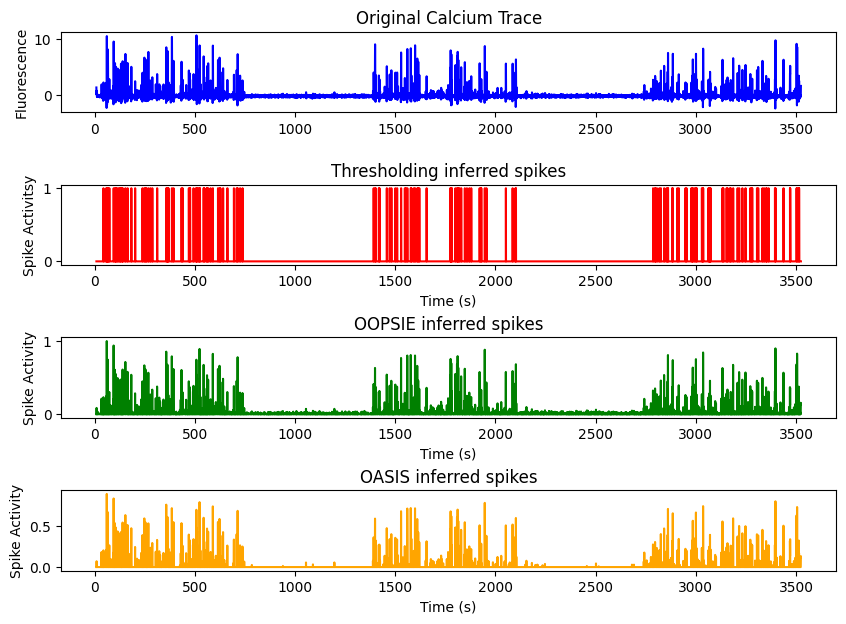

In [31]:
fig, axs = plt.subplots(
    4, 1, figsize=(10, 7), height_ratios=[1, 1, 1, 1], gridspec_kw=dict(hspace=0.9)
)

# Plot 1: Original Calcium Trace
axs[0].plot(time, example_neuron, label="Original Calcium", color="blue")
axs[0].set_ylabel("Fluorescence")
axs[0].set_title("Original Calcium Trace")

# Plot 2: Thresholding Inferred Spikes
axs[1].plot(time, threshold_spikes[60], label="Inferred Spikes", color="red")
axs[1].set_ylabel("Spike Activitsy")
axs[1].set_xlabel("Time (s)")
axs[1].set_title("Thresholding inferred spikes")

# Plot 3: OOPSI Inferred Spikes
axs[2].plot(time, oopsi_spikes[60, :], label="Inferred Spikes", color="green")
axs[2].set_ylabel("Spike Activity")
axs[2].set_xlabel("Time (s)")
axs[2].set_title("OOPSIE inferred spikes")

# Plot 4: OASIS Inferred Spikes
axs[3].plot(time, oasis_spikes[60, :], label="Inferred Spikes", color="ORANGE")
axs[3].set_ylabel("Spike Activity")
axs[3].set_xlabel("Time (s)")
axs[3].set_title("OASIS inferred spikes")

plt.show()

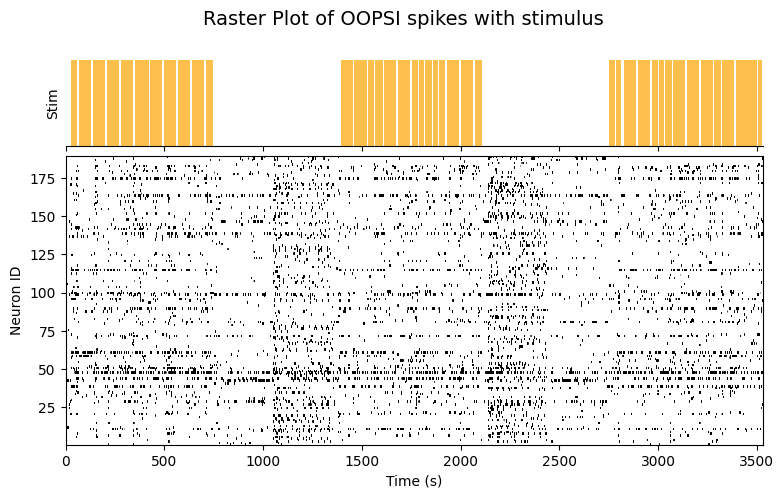

In [32]:
plot_raster_with_stimulus(
    oopsi_spikes,
    stim_epochs,
    stim_metadata,
    stimulus_name="locally_sparse_noise",
    threshold=0.2,
    sampling_rate=30,
    figsize=(9, 5),
    title="Raster Plot of OOPSI spikes with stimulus",
)

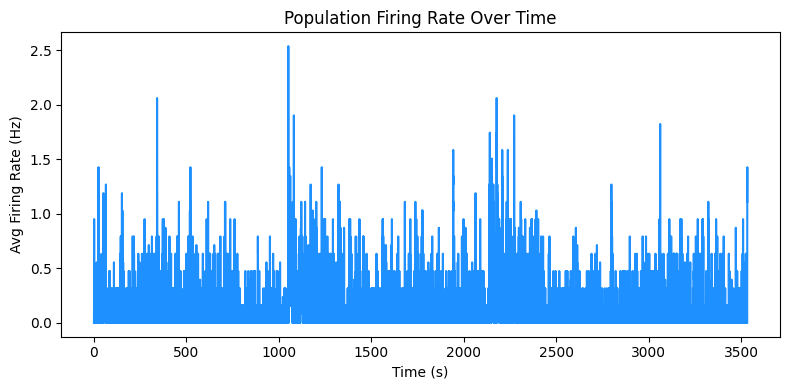

In [33]:
plot_population_firing_rate(
    oopsi_spikes, bin_size=2, sampling_rate=30, threshold=0.2, figsize=(8, 4)
)

### 2. Spike normalization

To ensure a fair and meaningful comparison between different spike inference methods, we first normalized the inferred spike trains across methods. This step is particularly important because methods like OASIS and OOPSI output continuous-valued spike estimates, where values may not reach 1 and often reflect spike probability or intensity rather than binary events. In contrast, our custom threshold-based approach directly produces binary spike trains (0 or 1), making it inherently discrete. To bring all methods onto a comparable scale, we normalized the OOPSI and OASIS outputs using z-score normalization and applied a common threshold (e.g., 0.2) to binarize the events. This allowed us to extract spike times consistently across methods and to quantify the number of detected spikes per neuron. These normalized and thresholded spike events were then converted into dataframes for systematic comparison, enabling both numerical summaries and visual analyses of spike detection performance.

In [34]:
def normalize_spikes(spike_array):
    """
    Normalize spike traces to [0, 1] range neuron-wise.

    Args:
        spike_array: 2D numpy array (neurons x timepoints)

    Returns:
        Normalized 2D numpy array of same shape.
    """
    norm_spikes = np.zeros_like(spike_array, dtype=float)
    for i in range(spike_array.shape[0]):
        trace = spike_array[i]
        if np.max(trace) != np.min(trace):  # avoid division by zero
            norm_spikes[i] = minmax_scale(trace)
        else:
            norm_spikes[i] = trace  # all-zero trace stays zero
    return norm_spikes

In [35]:
# Create DataFrames for more clear storage


# DataFrame for OOPSI and OASIS spikes
def spikes_to_df(spikes_array, fs, threshold=0.2):
    """
    Convert normalized spike traces into DataFrame of spike events using threshold.

    Args:
        spikes_array: 2D numpy array (neurons × timepoints), normalized [0,1]
        fs: sampling frequency in Hz
        threshold: value above which a spike is counted

    Returns:
        pd.DataFrame with columns: Neuron, TimeIdx, Time (seconds)
    """
    spike_events = []
    n_neurons, n_timepoints = spikes_array.shape

    for neuron_id in range(n_neurons):
        spike_idxs = np.where(spikes_array[neuron_id] > threshold)[0]
        for idx in spike_idxs:
            spike_events.append({"Neuron": neuron_id, "TimeIdx": idx, "Time": idx / fs})

    return pd.DataFrame(spike_events)


# DataFrame for thresholding spikes
def threshold_spikes_to_df(spikes_array, fs):
    """
    Convert binary threshold spikes array to DataFrame of spike events.

    Args:
        spikes_array: 2D numpy array (neurons x timepoints), binary 0/1
        fs: sampling frequency in Hz

    Returns:
        pd.DataFrame with columns: Neuron, TimeIdx, Time (seconds)
    """
    spike_events = []
    n_neurons, n_timepoints = spikes_array.shape
    for neuron_id in range(n_neurons):
        spike_idxs = np.where(spikes_array[neuron_id] == 1)[0]
        for idx in spike_idxs:
            spike_events.append({"Neuron": neuron_id, "TimeIdx": idx, "Time": idx / fs})
    return pd.DataFrame(spike_events)

In [36]:
# Normalize spikes for OOPSI and OASIS
oopsi_spikes_norm = normalize_spikes(oopsi_spikes)
oasis_spikes_norm = normalize_spikes(oasis_spikes)

# Threshold values for spike detection after normalization
oopsi_threshold = 0.2
oasis_threshold = 0.2

# Convert normalized spikes to DataFrames of events
oopsi_df = spikes_to_df(oopsi_spikes_norm, fs=fs, threshold=oopsi_threshold)
oasis_df = spikes_to_df(oasis_spikes_norm, fs=fs, threshold=oasis_threshold)

# Convert binary threshold spikes to DataFrame
threshold_df = threshold_spikes_to_df(threshold_spikes, fs=fs)

# Count spikes per neuron for each method
spike_counts_threshold = threshold_df["Neuron"].value_counts().sort_index()
spike_counts_oopsi = oopsi_df["Neuron"].value_counts().sort_index()
spike_counts_oasis = oasis_df["Neuron"].value_counts().sort_index()

# Combine into one single DataFrame:
spike_counts_df = (
    pd.DataFrame(
        {
            "Threshold": spike_counts_threshold,
            "OOPSI": spike_counts_oopsi,
            "OASIS": spike_counts_oasis,
        }
    )
    .fillna(0)
    .astype(int)
)

print("\nSpike Counts Per Neuron:\n")
print(spike_counts_df)


Spike Counts Per Neuron:

     Threshold  OOPSI  OASIS
0           24    115    129
1           21    134    136
2           34    480    466
3           77    180    184
4           19    153    143
..         ...    ...    ...
184         31    105    106
185         48     83     92
186         39    298    318
187         46    737    718
188         43    348    388

[189 rows x 3 columns]


### 3. Correlation Analysis

To evaluate the consistency between spike inference methods, we computed pairwise Pearson correlations based on the number of detected spikes per neuron across methods. This correlation matrix was visualized using a heatmap, where higher correlation values indicate stronger agreement between methods in terms of spike detection frequency. Additionally, we generated a pairplot of spike counts, which displays scatter plots for all method pairs along with kernel density estimates (KDEs) on the diagonal. This visualization provides a more detailed view of the relationships and potential biases between methods, revealing whether some systematically over- or under-estimate spike counts relative to others. Together, these analyses help assess the degree of alignment and reliability among the different spike inference techniques used in this study.


In [37]:
correlations = spike_counts_df.corr()

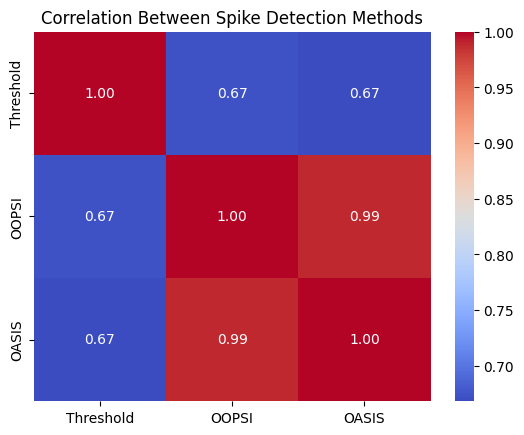

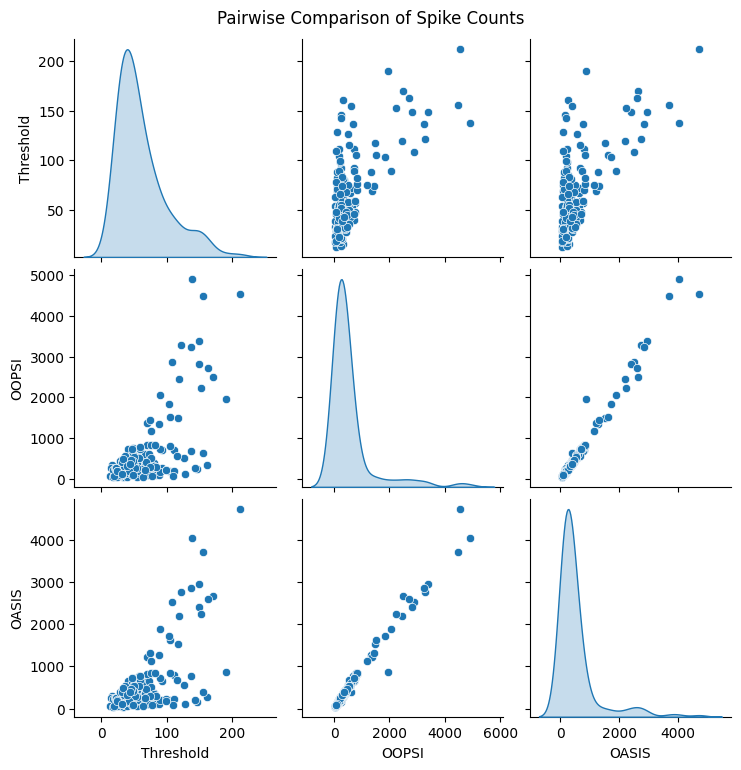

In [38]:
# Visualize correlations

# Heatmap visualization
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Spike Detection Methods")
plt.show()

# Pairwise comparison visualization
sns.pairplot(spike_counts_df, diag_kind="kde")
plt.suptitle("Pairwise Comparison of Spike Counts", y=1.02)
plt.show()

From the plots above, it can be observed that the OOPSI and OASIS spike inference methods yield extremely similar results, with a Pearson correlation coefficient of 0.99 in terms of total spike counts per neuron. This near-perfect agreement suggests that both model-based approaches are capturing highly consistent neural dynamics and likely share similar assumptions about calcium kinetics and noise characteristics. In contrast, both OOPSI and OASIS show moderate correlations of 0.67 with the thresholding-based method, indicating a noticeable divergence. This suggests that thresholding captures some broad trends in spiking activity but may miss subtler events or overcount spurious transients due to its lack of temporal smoothing or biophysical modeling.

The pairwise distribution plots reinforce these findings. They show a tight, linear relationship between OOPSI and OASIS spike counts across neurons, while the thresholding method displays a wider spread when compared to either. This spread reflects inconsistencies in spike detection, particularly for neurons with intermediate levels of activity. Furthermore, the kernel density estimates (KDEs) along the diagonal reveal that OOPSI and OASIS produce more similar spike count distributions—typically unimodal and centered—while the thresholding method sometimes yields broader or skewed distributions. These visual and statistical comparisons together support the conclusion that model-based methods (OOPSI and OASIS) provide more consistent and reliable spike inference than simple thresholding, especially for subtle or noisy calcium signals.


Given these findings, we decided to carry out the subsequent analysis with the results yielded by the OASIS spike inference method.

## Receptive Fields Fitting

For Receptive Field estimation, we have implemented the following methods:

1. Spike-Triggered Average (STA)

2. Linear N Poisson (LNP):
- 2.1 Regularization
- 2.2 STA initialization

3. Berens rfest library implementation methods:
- 3.1
- 3.2

## 1. Spike-Triggered Average

A classical method used to estimate a neuron's receptive field or stimulus preference by averaging the stimuli that precede its spikes. This method assumes that spikes are more likely to occur when specific stimulus patterns are present, and thus, averaging the preceding stimuli provides an estimate of what features the neuron is sensitive to.

In [39]:
def compute_sta_for_neuron(
    spike_trace, stims, stim_metadata, Dx, Dy, bin_size=2, n_lags=7
):
    """
    Compute spike-triggered average (STA) for a single neuron.

    Args:
        neuron_id (int): ID of neuron.
        spike_traces (ndarray): Shape (n_neurons, n_frames)
        stims (ndarray): Shape (n_unique_stims, Dx, Dy)
        stim_metadata (pd.DataFrame): Must contain 'frame', 'start', 'end'
        Dx, Dy (int): Stimulus dimensions
        bin_size (int): Number of frames per bin
        n_lags (int): Number of time bins to look back

    Returns:
        sta (np.ndarray): shape (n_lags, Dx, Dy)
    """
    n_frames = spike_trace.shape[0]
    stim_trace = np.full((n_frames, Dx, Dy), 0.0, dtype=np.float32)

    # Fill stimulus trace
    for i, row in stim_metadata.iterrows():
        stim_idx = row["frame"]
        start = row["start"]
        end = row["end"]
        stim_trace[start:end] = np.tile(stims[stim_idx], (end - start, 1, 1))

    # Bin spikes and stimuli

    n_bins = n_frames // bin_size
    n_trim = n_bins * bin_size

    spikes_binned = spike_trace[:n_trim].reshape(n_bins, bin_size).sum(axis=1)
    stim_binned = stim_trace[:n_trim].reshape(n_bins, bin_size, Dx, Dy).mean(axis=1)

    # Flatten stimuli
    pixels = Dx * Dy
    stim_flat = stim_binned.reshape(n_bins, pixels).T  # shape: (pixels, n_bins)

    # Compute STA
    sta = np.zeros((pixels, n_lags))
    valid_spike_count = 0

    for i in range(n_lags, n_bins):
        spike_val = spikes_binned[i]
        if spike_val > 0:
            sta += stim_flat[:, i - n_lags : i] * spike_val
            valid_spike_count += spike_val

    sta /= valid_spike_count + 1e-10  # avoid divide-by-zero
    return sta

In [40]:
def compute_sta_for_neuron_list(
    neuron_ids, oasis_spikes, stims, stim_metadata, bin_size=2, n_lags=7
):
    """
    Compute STAs for a list of neuron indices.

    Returns:
        stas (np.ndarray): shape (n_neurons, n_lags, Dx, Dy)
    """
    Dx, Dy = stims.shape[1:]
    stas = []

    for neuron_id in neuron_ids:
        spike_trace = oasis_spikes[neuron_id]
        sta = compute_sta_for_neuron(
            spike_trace,
            stims,
            stim_metadata,
            Dx,
            Dy,
            bin_size=bin_size,
            n_lags=n_lags,
        )
        stas.append(sta)

    return np.stack(stas, axis=0)  # shape: (n_neurons, n_lags, Dx, Dy)

### 1.1 STA visualization

Given that our dataset contains calcium traces for 189 neurons, we selected the top five most active neurons as well as neurons with ON/OFF activity for STA visualization.

In [41]:
def plot_sta_grid(
    stas, neurons, Dx, Dy, cmap="bwr", title="STA Montage", vmin=None, vmax=None
):
    """
    Plot STA(s) with neuron IDs as y-axis labels and well-aligned colorbars.

    Parameters:
    - stas: (n_neurons, Dx*Dy, n_lags) or (Dx*Dy, n_lags)
    - neurons: list of neuron IDs or single neuron id
    - Dx, Dy: stimulus spatial dims
    - cmap: colormap
    - title: figure title
    - vmin, vmax: color scaling limits
    """
    # Normalize input shape & neuron IDs
    if stas.ndim == 2:
        stas = stas[np.newaxis, ...]
    if isinstance(neurons, int):
        neurons = [neurons]

    n_neurons, _, n_lags = stas.shape

    fig = plt.figure(figsize=(2.5 * n_lags + 1, 2.5 * n_neurons))
    gs = GridSpec(
        n_neurons,
        n_lags + 1,
        width_ratios=[1] * n_lags + [0.05],
        wspace=0.1,
        hspace=0.3,
    )

    for i in range(n_neurons):
        for j in range(n_lags):
            ax = fig.add_subplot(gs[i, j])
            frame = stas[i, :, j].reshape(Dx, Dy)
            im = ax.imshow(
                gaussian_filter(frame, sigma=1),
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
            )
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines[:].set_visible(False)
            if i == 0:
                ax.set_title(f"Lag -{j}", fontsize=10)

            # Add neuron ID label only on first column, centered vertically
            if j == 0:
                ax.set_ylabel(
                    f"Neuron {neurons[i]}",
                    fontsize=10,
                    rotation=90,
                    labelpad=15,
                    # va="center",
                )

        # Add colorbar for each neuron row in the last column
        cax = fig.add_subplot(gs[i, -1])
        plt.colorbar(im, cax=cax)
        cax.yaxis.set_ticks_position("right")
        cax.yaxis.set_label_position("right")

    fig.suptitle(title, fontsize=16)
    plt.show()

In [42]:
# Top 5 most active neurons

# Choose a spike detection threshold
spike_threshold = np.percentile(oasis_spikes, 99)

# Binary spike detection
binary_spikes = oasis_spikes > spike_threshold

# Count spikes per neuron
spike_counts = binary_spikes.sum(axis=1)

# Sort to find most active
top_5_active = np.argsort(spike_counts)[-5:]

# Parameters
bin_size = 2
Dx, Dy = stims.shape[1:]
n_lags = 7

In [43]:
# Top 5 most active neurons implementation

active_stas = compute_sta_for_neuron_list(
    top_5_active, oasis_spikes, stims, stim_metadata, bin_size=bin_size, n_lags=n_lags
)

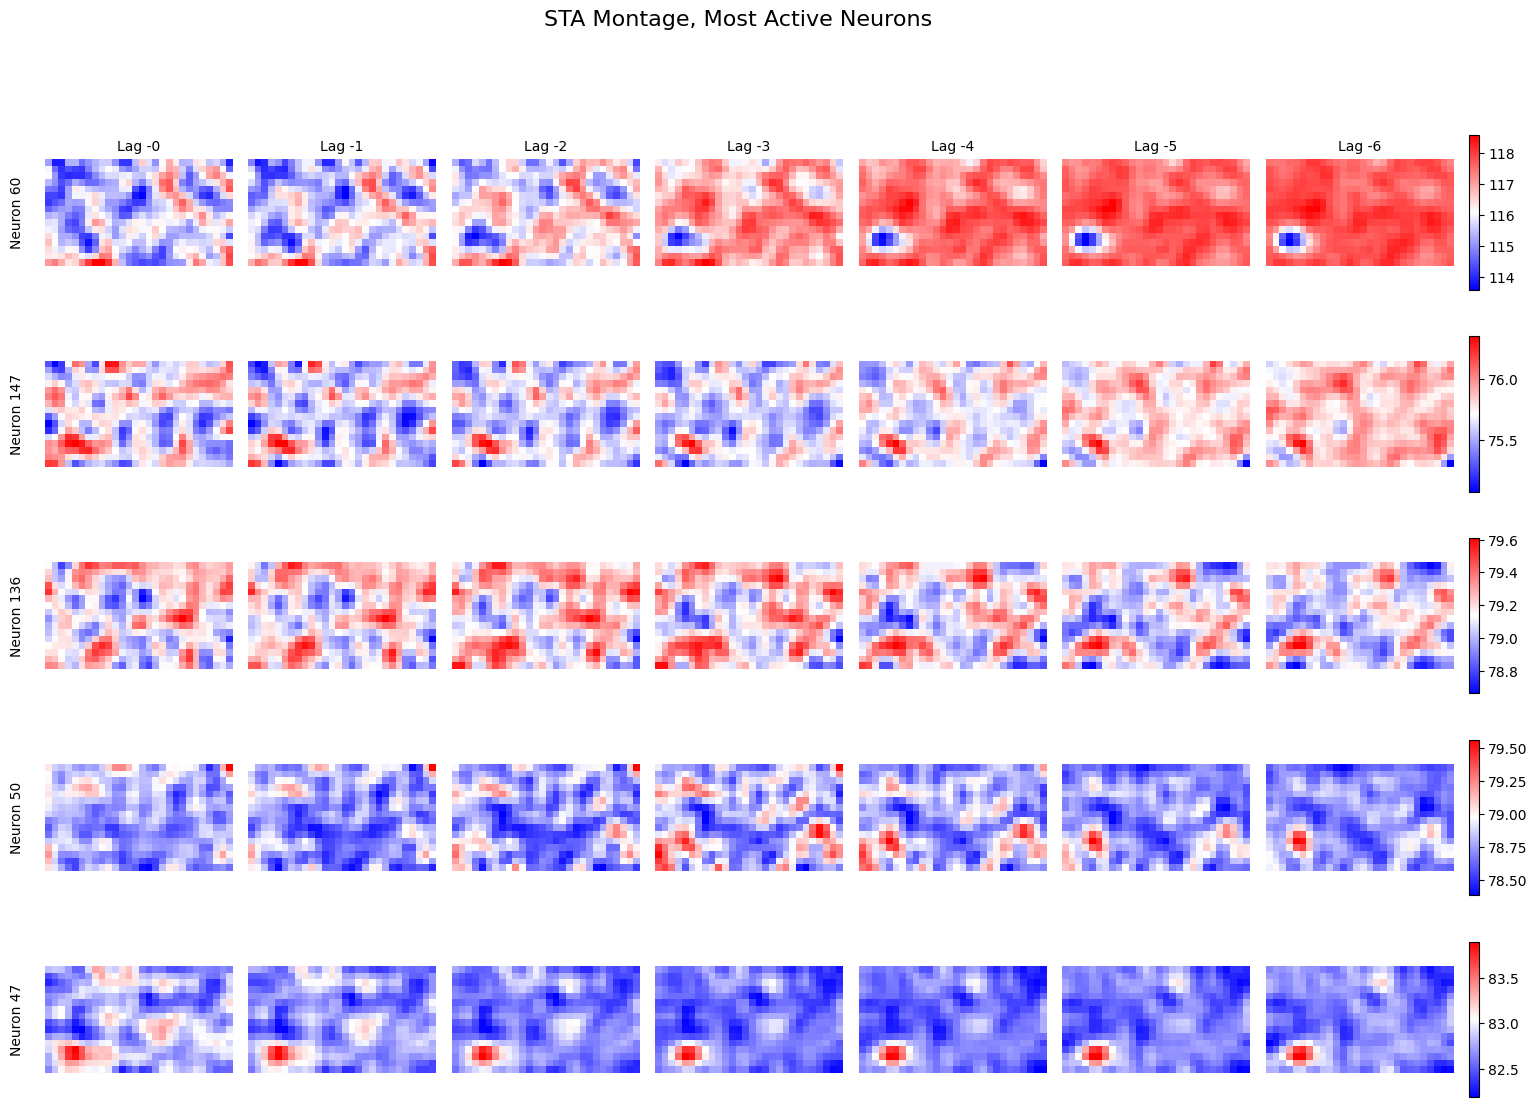

In [44]:
# Top 5 most active neurons plot
plot_sta_grid(
    active_stas,
    top_5_active,
    Dx,
    Dy,
    cmap="bwr",
    title="STA Montage, Most Active Neurons",
    vmin=None,
    vmax=None,
)

In [45]:
# ON/OFF activity neurons
def count_active_bouts(spike_trace, threshold=0.2, min_gap=20):
    # Binary thresholded spike presence
    binary = spike_trace > threshold
    # Label connected regions (bouts of activity)
    labeled, n_bouts = label(binary)
    return n_bouts


# Apply to all neurons
bouts_per_neuron = np.array([count_active_bouts(trace) for trace in oasis_spikes])

# ON-OFF-like behavior: neurons with ~2 or more clear bouts
on_off_like_indices = np.where((bouts_per_neuron >= 90))[0]
on_off_like_indices = on_off_like_indices[5:10]

In [46]:
# ON/OFF activity neurons implementation

onoff_stas = compute_sta_for_neuron_list(
    on_off_like_indices,
    oasis_spikes,
    stims,
    stim_metadata,
    bin_size=bin_size,
    n_lags=n_lags,
)

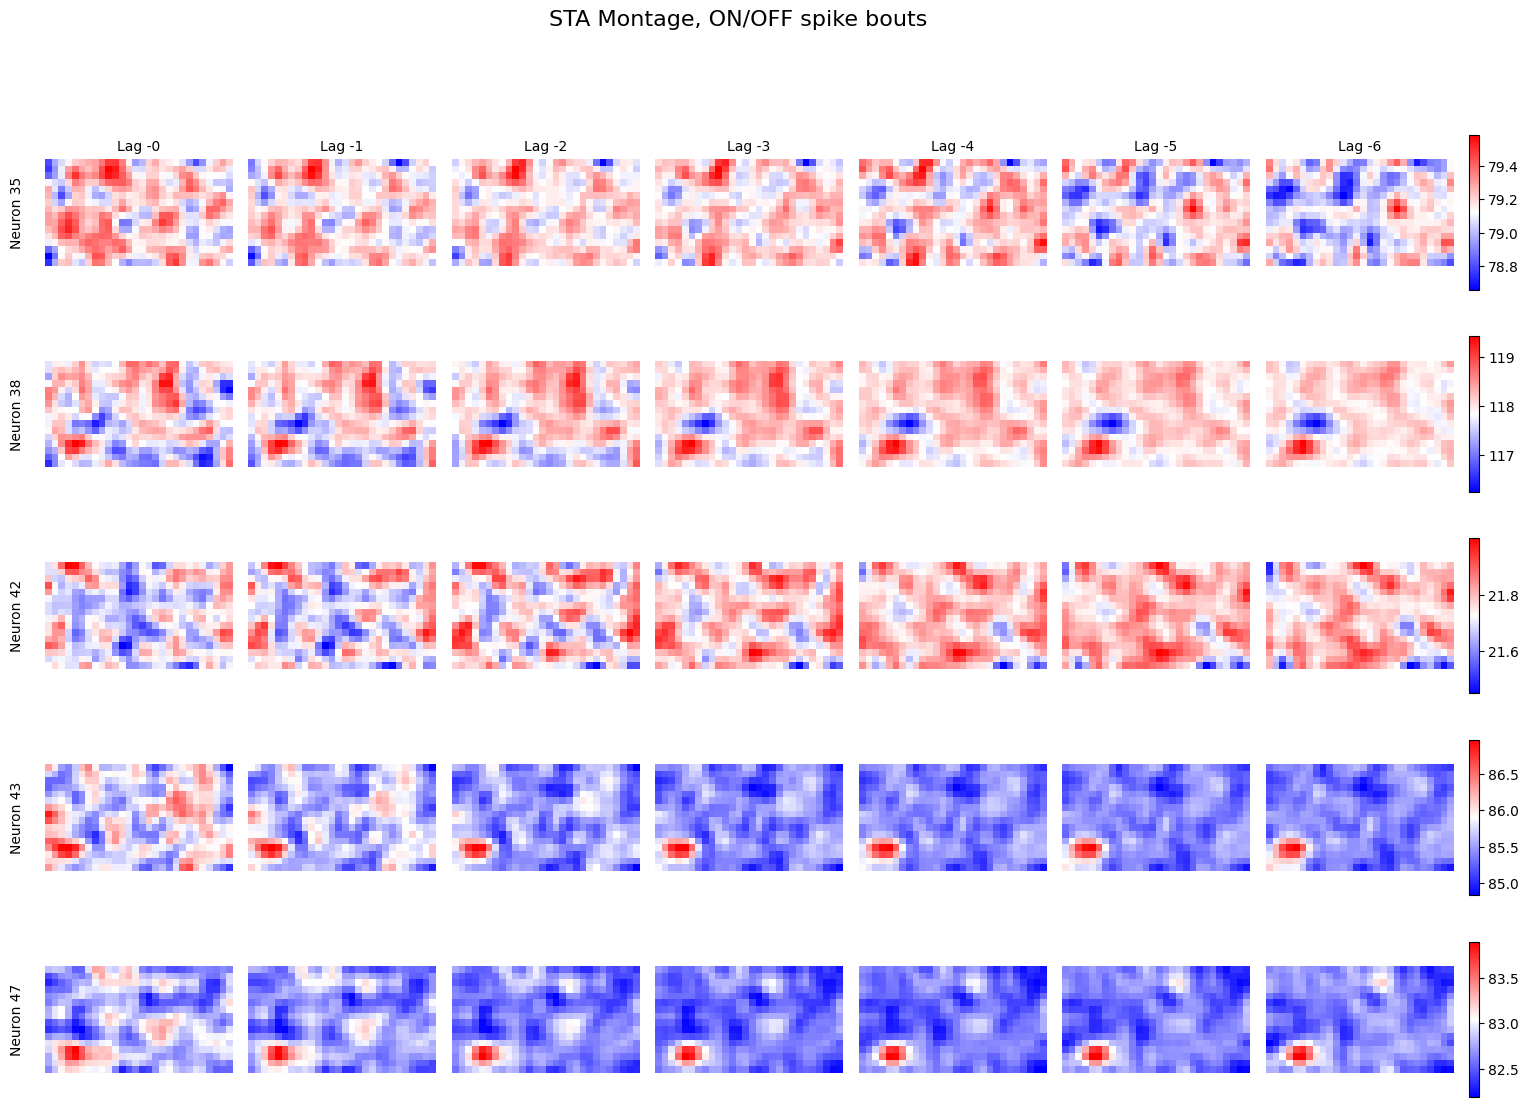

In [47]:
# ON/OFF activity neurons plot
plot_sta_grid(
    onoff_stas,
    on_off_like_indices,
    Dx,
    Dy,
    cmap="bwr",
    title="STA Montage, ON/OFF spike bouts",
    vmin=None,
    vmax=None,
)

### 1.2 Spatial temporal kernel

To better interpret the receptive field (RF) obtained from the spike-triggered average (STA), we decompose it into **spatial** and **temporal** components using **Singular Value Decomposition (SVD)**. The STA is originally a 3D array representing spatial dimensions (pixels) over multiple time lags.

We first reshape the STA into a 2D matrix, where each row corresponds to a spatial pixel (flattened), and each column corresponds to a time lag. This matrix captures how each pixel's intensity at each time lag relates to the neuron’s activity.

The key assumption here is **separability**: the neuron’s response can be approximated as the product of a spatial pattern and a temporal pattern, independently influencing firing.

Using SVD on the reshaped and mean-centered STA matrix, we factorize it into three matrices, which allows us to extract:

* A **spatial kernel**: a vector representing the spatial pattern of stimulus pixels most relevant to the neuron, reshaped back to the original spatial dimensions (width × height).
* A **temporal kernel**: a vector representing how the neuron’s firing depends on stimulus history over time (the temporal lags).

The first spatial and temporal singular vectors capture the dominant features of the receptive field, providing a compact and interpretable summary. This decomposition simplifies comparisons across neurons and different estimation methods by separating the spatial and temporal contributions to neural responses.


In [48]:
def compute_spatial_temporal_kernel(sta, Dx, Dy, n_lags, bin_size):

    # --- SVD
    pixels = Dx * Dy
    sta_matrix = sta.reshape(pixels, n_lags)
    sta_centered = sta_matrix - sta_matrix.mean(axis=1, keepdims=True)

    U, S, VT = np.linalg.svd(sta_centered, full_matrices=False)
    spatial_kernel = U[:, 0].reshape(Dx, Dy)
    temporal_kernel = VT[0, :]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(spatial_kernel, cmap="bwr")
    plt.colorbar()
    plt.title("Spatial Kernel")

    plt.subplot(1, 2, 2)
    time_axis = np.arange(-n_lags, 0) * bin_size * 1000 / 30  # ms
    plt.plot(time_axis, temporal_kernel)
    plt.xlabel("Time before spike (ms)")
    plt.title("Temporal Kernel")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

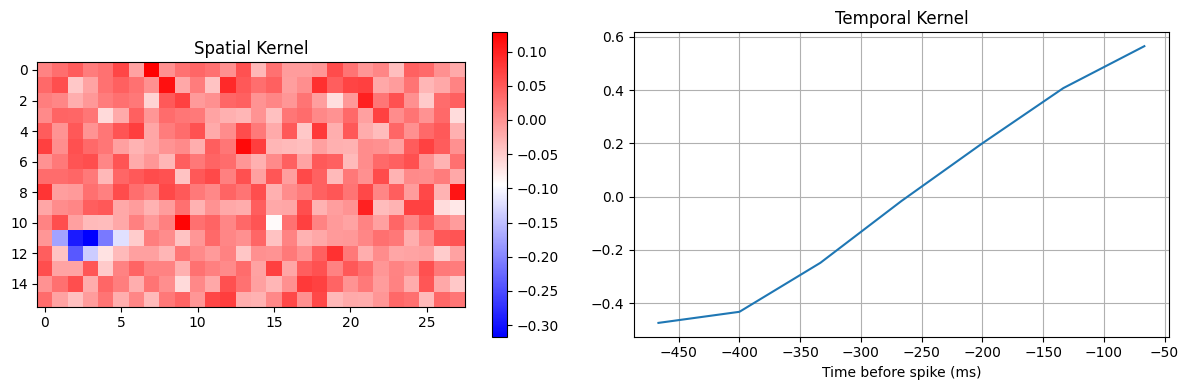

In [49]:
spike_trace = oasis_spikes[114]
sta = compute_sta_for_neuron(
    spike_trace, stims, stim_metadata, Dx, Dy, bin_size, n_lags
)
compute_spatial_temporal_kernel(sta, Dx, Dy, n_lags, bin_size)

The plot reveals that...

## 2. Linear-Nonlinear Poisson (LNP)

The LNP framework models a neuron's response as a linear projection of the stimulus onto a filter (the receptive field), followed by a nonlinear transformation (e.g., exponential or soft-rectification), and finally a Poisson spike generation process. This probabilistic modeling approach accounts for both stimulus encoding and neural noise, making it more expressive and accurate than STA under realistic conditions.

To improve estimation we also implemented Lasso (L1) regularization during fitting, encouraging sparsity in the receptive field and reducing overfitting, especially important when dealing with high-dimensional stimuli and limited data. This regularization can help isolate the most informative spatial and temporal features driving neural responses, resulting in cleaner and more interpretable receptive field estimates


In [50]:
# Initialize parameters

neuron_id = 60
spike_threshold = 0.2
bin_size = 2
lags = [0, 1, 2, 3, 4]
R = 50
frame_rate_hz = 30
frame_dt = 1.0 / frame_rate_hz

In [51]:
# 1. Compute spike counts


def compute_spike_counts_from_trace(spike_trace, stim_metadata, valid_frame_indices):
    counts = []
    for idx in valid_frame_indices:
        row = stim_metadata.iloc[idx]
        start = int(row["start"])
        end = int(row["end"])
        # Sum deconvolved spikes (can be fractional). If you prefer "counts",
        # you could round or threshold here, but we are explicitly *not* thresholding.
        counts.append(np.sum(spike_trace[start:end]))
    return np.asarray(counts, dtype=float)

In [52]:
# 2. Gather the stimulus frames without binninb
def gather_stimulus_frames(stim_metadata, stims, valid_frame_indices):
    frame_ids = stim_metadata.iloc[valid_frame_indices]["frame"].values.astype(int)
    stim_list = [stims[f] for f in frame_ids]
    return np.stack(stim_list, axis=0)

In [53]:
# 3. Get valid stimulus frame indices

lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]
valid_indices = []
for _, row in lsn_epochs.iterrows():
    valid = stim_metadata[
        (stim_metadata["start"] >= row["start"]) & (stim_metadata["end"] <= row["end"])
    ]
    valid_indices.extend(valid.index.tolist())

# Sort (just in case epochs appended out of order)
valid_indices = sorted(valid_indices)

In [54]:
# 4. Compute *framewise* spike counts

framewise_spike_counts = compute_spike_counts_from_trace(
    oasis_spikes[neuron_id, :], stim_metadata, valid_indices
)

In [55]:
# 5. Gather matching stimulus frames
stims_framewise = gather_stimulus_frames(stim_metadata, stims, valid_indices)

# Sanity alignment
assert len(framewise_spike_counts) == stims_framewise.shape[0], (
    "Spike counts and stimulus frames length mismatch: "
    f"{len(framewise_spike_counts)} vs {stims_framewise.shape[0]}"
)

In [56]:
# 6. Normalize stimuli (z-score across all selected frames)

stim_mean = stims_framewise.mean()
stim_std = stims_framewise.std()
if stim_std == 0:
    raise ValueError("Stimulus std is zero; cannot z-score.")
stims_norm = (stims_framewise - stim_mean) / stim_std

In [57]:
# 7. LNP Model Fitting


def fit_receptive_field_lnp(spike_counts, stims, lags, dt, R=50):
    """Fit a space-time LNP receptive field using Poisson likelihood.

    Parameters
    ----------
    spike_counts : (T,) array of spike counts per frame.
    stims        : (T, Dx, Dy) array of stimuli (already normalized if desired).
    lags         : list of non-negative integers specifying #frames back.
    dt           : float, duration (s) per frame.
    R            : scalar gain multiplying exp(linear drive).

    Returns
    -------
    rf : (Dx, Dy, n_lags) array of fitted weights.
    """
    Dx, Dy = stims.shape[1:]
    n_frames = stims.shape[0]
    stim_reshaped = stims.reshape(n_frames, Dx * Dy).T  # (Px, T)
    w_hat = np.zeros((Dx * Dy, len(lags)))

    for i, lag in enumerate(lags):
        if lag > 0:
            s_lag = stim_reshaped[:, :-lag]  # drop last 'lag' frames of stim
            c_lag = spike_counts[lag:]  # drop first 'lag' counts so lengths match
        else:
            s_lag = stim_reshaped
            c_lag = spike_counts

        # Negative log-likelihood and gradient
        def negloglike(w, dt, R):
            # (Px,) dot (Px,T) -> (T,)
            lin_drive = np.clip(w.T @ s_lag, -20, 20)  # numeric stability
            r = np.exp(lin_drive) * dt * R
            r = np.maximum(r, 1e-12)
            val = -np.sum(c_lag * np.log(r) - r - gammaln(c_lag + 1))
            if not np.isfinite(val):
                print("Non-finite negloglike:", val)
            return val

        def dnegloglike(w, dt, R):
            lin_drive = np.clip(w.T @ s_lag, -20, 20)
            r = np.exp(lin_drive) * dt * R
            r = np.maximum(r, 1e-12)
            grad = s_lag @ (r - c_lag)
            if not np.all(np.isfinite(grad)):
                print("Non-finite gradient detected.")
            return grad

        w0 = np.random.randn(Dx * Dy) * 0.1
        res = minimize(
            partial(negloglike, dt=dt, R=R),
            w0,
            jac=partial(dnegloglike, dt=dt, R=R),
            method="L-BFGS-B",
            options={"maxiter": 1000, "gtol": 1e-5},
        )
        if not res.success:
            print(f"Optimization failed at lag {lag}: {res.message}")
        w_hat[:, i] = res.x

    return w_hat.reshape(Dx, Dy, len(lags))

In [58]:
# Plotting


def plot_rf(rf, cmap="bwr", title="Receptive Field", vmin=None, vmax=None):
    n_lags = rf.shape[-1]
    fig, axs = plt.subplots(1, n_lags, figsize=(n_lags * 3, 3), constrained_layout=True)
    if n_lags == 1:
        axs = [axs]  # Make axs always iterable

    vmin = np.min(rf) if vmin is None else vmin
    vmax = np.max(rf) if vmax is None else vmax

    for i in range(n_lags):
        axs[i].imshow(
            gaussian_filter(rf[:, :, i], sigma=1), cmap=cmap, vmin=vmin, vmax=vmax
        )
        axs[i].set_title(f"Lag {lags[i]}")
        axs[i].axis("off")

    fig.colorbar(axs[0].images[0], ax=axs, orientation="vertical", shrink=0.8)
    fig.suptitle(title)
    plt.show()

In [59]:
# Fit LNP model
rf = fit_receptive_field_lnp(framewise_spike_counts, stims_norm, lags, frame_dt, R=R)

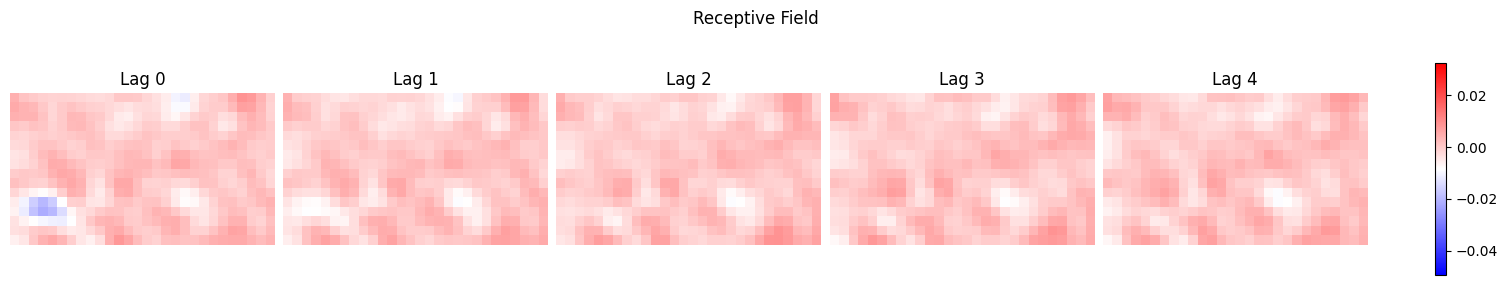

In [60]:
# Plot LNP model

plot_rf(rf)

After implementing the LNP model, the resulting receptive fields for the example neuron appeared weak or lacked clear spatial structure. This could be due to several limitations inherent in the basic LNP formulation. The model relies on fitting a linear filter followed by a fixed nonlinearity, assuming that this transformation sufficiently captures the neuron's encoding process. 

To better understand why the LNP model might be underperforming, we analyzed the spike count statistics across time using a simple spike count diagnostic plot. By visualizing the number of spikes in each stimulus time bin and computing basic statistics (minimum, maximum, mean, and the proportion of zero-spike bins), we assessed whether the neuron exhibited enough activity for the model to learn from. A high proportion of bins with no spikes may indicate insufficient signal in the data, making it harder for the model to detect consistent stimulus-response patterns.

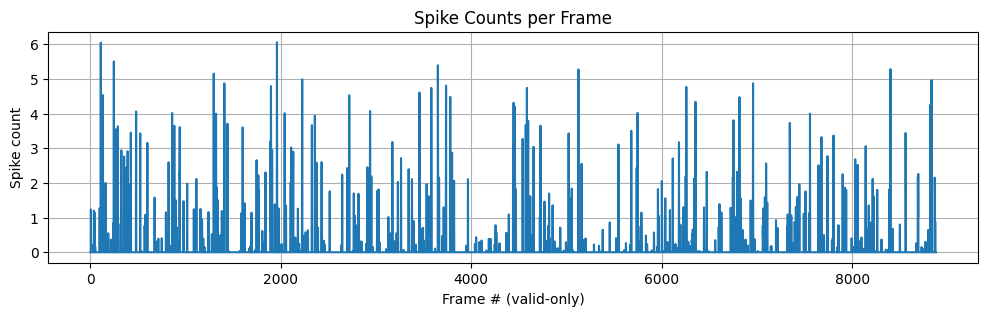

Min spike count: 0.0
Max spike count: 6.058916380714144
Mean spike count: 0.12523355101699665
Fraction zero frames: 0.8942567567567568


In [61]:
# Diagnostics: spike count trace

plt.figure(figsize=(12, 3))
plt.plot(framewise_spike_counts)
plt.title("Spike Counts per Frame")
plt.xlabel("Frame # (valid-only)")
plt.ylabel("Spike count")
plt.grid(True)
plt.show()

print("Min spike count:", np.min(framewise_spike_counts))
print("Max spike count:", np.max(framewise_spike_counts))
print("Mean spike count:", np.mean(framewise_spike_counts))
print("Fraction zero frames:", np.mean(framewise_spike_counts == 0))

Supporting this interpretation, the spike count diagnostics reveal that the neural activity is very sparse: the minimum spike count per time bin is zero, the maximum is approximately 6 spikes, and the mean spike count is low at around 0.125 spikes per bin. Moreover, nearly 89.4% of the time bins contain zero spikes. This extreme sparsity makes it challenging for any model to reliably estimate the receptive field because there are too few events driving the neural responses.

In such cases, standard linear or generalized linear models may struggle to capture meaningful structure, as the data do not contain enough informative spikes to constrain the model parameters.

### Lasso Regularization

We have fitted a LNP with Lasso Regularization for values of alpha equal to 0.001, 0.01 and 0.1.

In [62]:
# Lasso Fitting Function


def fit_receptive_field_lasso(spike_counts, stims, lags, alpha=0.01, max_iter=10000):
    Dx, Dy = stims.shape[1:3]
    n_frames = stims.shape[0]
    n_lags = len(lags)

    stim_reshaped = stims.reshape(n_frames, Dx * Dy).T  # (pixels, time)
    w_hat = np.zeros((Dx * Dy, n_lags))

    for i, lag in enumerate(lags):
        if lag > 0:
            s_lag = stim_reshaped[:, :-lag].T  # (time-lag, pixels)
            c_lag = spike_counts[lag:]  # (time-lag,)
        else:
            s_lag = stim_reshaped.T  # (time, pixels)
            c_lag = spike_counts  # (time,)

        model = Lasso(alpha=alpha, max_iter=max_iter, random_state=42)
        model.fit(s_lag, c_lag)
        w_hat[:, i] = model.coef_

    return w_hat.reshape(Dx, Dy, n_lags)

In [63]:
# Lasso Sweep

alphas = [0.001, 0.01, 0.1]
rf_lasso_dict = {}

for alpha in alphas:
    print(f" Fitting Lasso with alpha={alpha}")
    rf_lasso = fit_receptive_field_lasso(
        framewise_spike_counts, stims_norm, lags, alpha=alpha
    )

    rf_lasso_dict[alpha] = rf_lasso

 Fitting Lasso with alpha=0.001
 Fitting Lasso with alpha=0.01
 Fitting Lasso with alpha=0.1


 Plotting RF for alpha=0.001


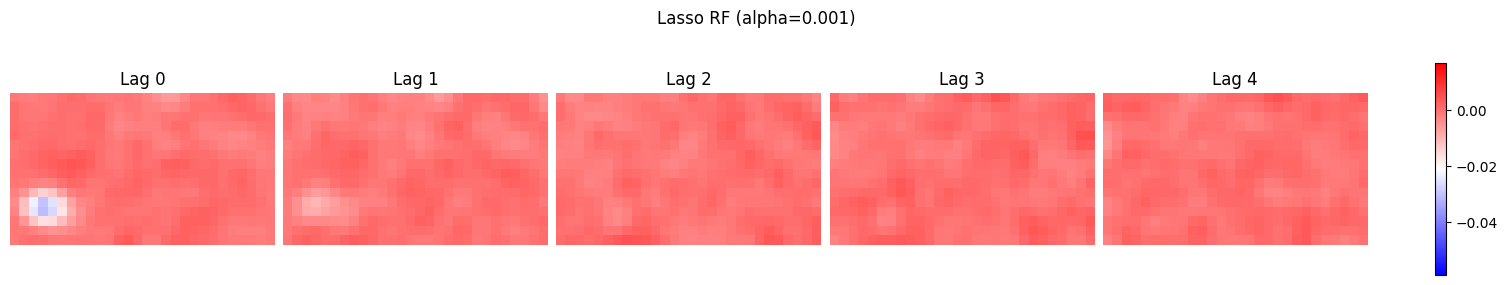

 Plotting RF for alpha=0.01


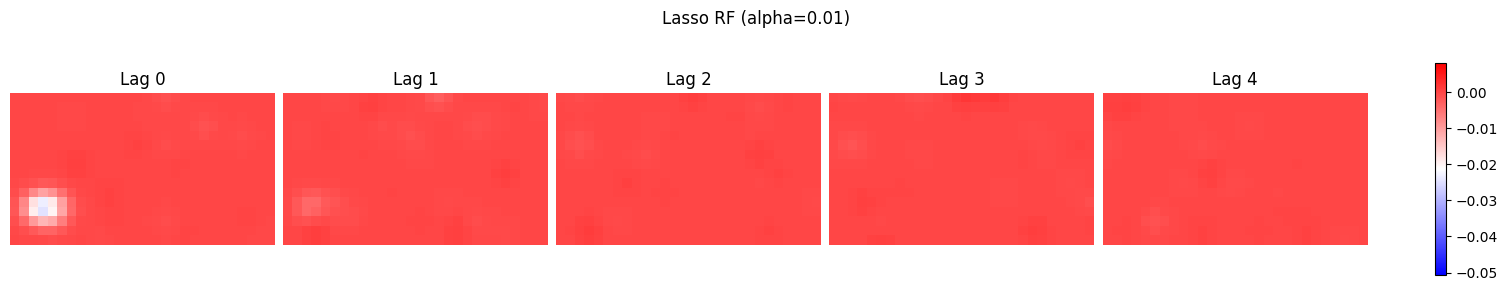

 Plotting RF for alpha=0.1


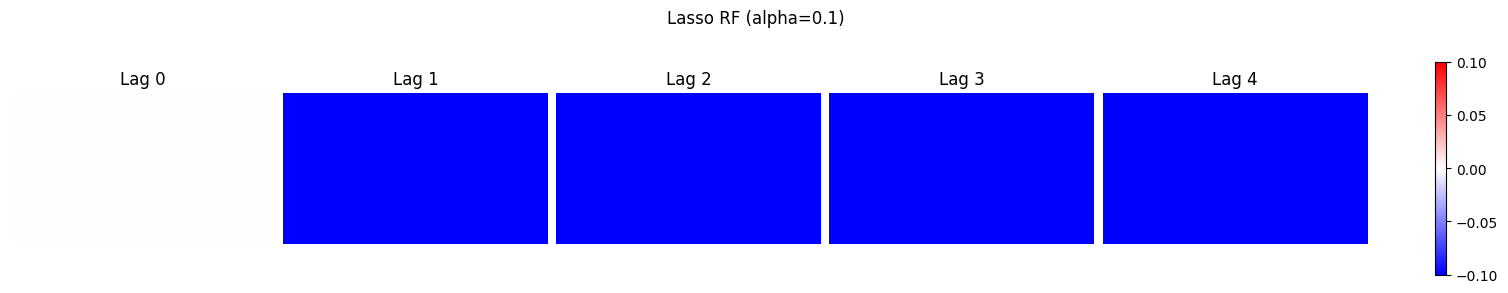

Max coefficient: 0.0


In [64]:
# Visualize Results

for alpha in alphas:
    print(f" Plotting RF for alpha={alpha}")
    plot_rf(rf_lasso_dict[alpha], title=f"Lasso RF (alpha={alpha})")

rf = rf_lasso_dict[0.1]
print("Max coefficient:", np.max(np.abs(rf)))

The Lasso regression results indicate poor receptive field (RF) fitting for the current data and parameter settings. Specifically, when using an alpha value of 0.1, which controls the strength of the L1 regularization penalty, the model’s coefficients reach their maximum absolute values (Max coefficient: 0.0). This suggests that the Lasso penalty is either too strong or not well-tuned for the data, causing the model to zero out many coefficients and potentially underfit the receptive field.

## 3. Receptive Field Estimation Methods with RFEst v2


To extend our analysis and compare a diverse set of receptive field (RF) estimation techniques, we utilized the **RFEst v2** Python toolbox. This open-source library provides a comprehensive and modular framework for modeling and fitting receptive fields using several well-established statistical and machine learning methods. The methods implemented in RFEst range from simple matrix-based estimators to probabilistic Bayesian approaches and more flexible, nonlinear models.

### 1. STA and MLE (Matrix-based Estimators)

- **Spike-Triggered Average (STA):**  
  The STA is the simplest RF estimation method and acts as a first-order approximation of the linear filter. It is computed by averaging the stimuli that preceded each spike, assuming the neuron's firing rate is linearly related to the stimulus:  
  `w_sta = X.T @ y`  
  This operation accumulates stimulus patterns that triggered spikes.

- **Maximum Likelihood Estimation (MLE):**  
  MLE extends STA by finding the linear weights `w` that best predict the spike counts via least squares regression:  
  `w_mle = np.linalg.inv(X.T @ X) @ X.T @ y`  
  It assumes a linear response model with Gaussian noise and no regularization.



### 2. Empirical Bayes with Structured Gaussian Priors

- **Automatic Smoothness Determination (ASD):**  
  ASD is a Bayesian linear regression model that imposes a smoothness prior on the receptive field. It learns the strength and spatial scale of this smoothness directly from data, promoting smooth, biologically plausible filters.

- **Automatic Locality Determination (ALD):**  
  ALD generalizes ASD by allowing non-stationary priors, meaning it can adapt spatial smoothness and localization differently across the receptive field, ideal for RFs with strong spatial structure.



### 3. Matrix Factorization Models

- **Linear-Nonlinear-Poisson (LNP):**  
  The LNP model assumes a neuron's firing rate is the result of a linear projection of the stimulus, passed through a fixed nonlinearity (e.g., exponential), then modeled with a Poisson spike generator. This captures both filtering and noise characteristics.

- **LNLN (Two-layer model):**  
  This extends LNP by using multiple linear filters, each followed by a nonlinearity, then summed and passed through another nonlinearity. It models more complex, biologically realistic processing like subunits or nonlinear pooling.



### 4. Spline-based Generalized Linear Models

- **splineLNP:**  
  A flexible version of LNP where the nonlinearity is not fixed but instead learned from the data using spline basis functions.

- **splineLNLN:**  
  The most flexible model, applying splines to both the subunit-level and final-stage nonlinearities. This allows it to capture highly nonlinear computations found in complex neural systems.



In [65]:
# Set up parameters to build stimulus matrix

Dx, Dy = stims.shape[1:]
dims = [Dx, Dy]
df = [int(np.maximum(np.ceil(dim / 2), 3)) for dim in list(dims)]

In [66]:
def build_stimulus_matrix(stims, stim_epochs, stim_metadata, trace_length):
    """
    Builds stimulus matrix `s` of shape (Dx * Dy, nT), where each column is the stimulus
    shown at that timepoint, or zeros if no stimulus was shown.

    Parameters:
        stims: np.array of shape (9000, Dx, Dy)
        stim_epochs: pd.DataFrame with 'stimulus', 'start', 'end'
        stim_metadata: pd.DataFrame with 'frame', 'start', 'end'
        trace_length: int, number of timepoints in spike train

    Returns:
        s: np.array of shape (Dx*Dy, nT)
    """

    Dx, Dy = stims.shape[1], stims.shape[2]
    nT = trace_length
    s = np.zeros((nT, Dx, Dy), dtype=stims.dtype)

    # Filter epochs for locally sparse noise
    lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]

    # Flatten each stim frame once
    flat_stims = stims.reshape(stims.shape[0], -1)  # shape (9000, Dx*Dy)

    # Loop through all metadata rows and check if the frame belongs to LSN
    for _, row in stim_metadata.iterrows():
        frame = row["frame"]
        t_start = int(row["start"])
        t_end = int(row["end"])

        # Check if this frame falls within any LSN epoch
        in_lsn = any(
            (t_start >= epoch_start) and (t_end <= epoch_end)
            for epoch_start, epoch_end in zip(lsn_epochs["start"], lsn_epochs["end"])
        )
        if in_lsn and frame < len(flat_stims):
            # Fill in the same stimulus vector across the time window
            s[t_start:t_end, :] = stims[frame]
            # [:, np.newaxis]
    s = s.reshape(nT, Dx, Dy)
    return s

In [67]:
# Set up parameters to calculate stim matrix
trace_length = len(oasis_spikes[0, :])
stims_valid = build_stimulus_matrix(stims, stim_epochs, stim_metadata, trace_length)

n_stim = stims_valid.shape[0]
X = build_design_matrix(stims_valid.reshape((n_stim, -1)), 1)

For simplicity and time saving we will analyze neurons 38 and 60, which are high activity neurons

In [68]:
# Neurons to analyze
neuron_indices = [38, 60]  # Add more indices here if needed

# Container to store filters for each neuron and method
filters = {idx: {} for idx in neuron_indices}

### 1. STA and MLE (Matrix-based Estimators)

In [82]:
for idx in neuron_indices:
    print(f"Processing neuron {idx}")
    y = oasis_spikes[idx, :]

    # STA
    w_sta = X.T @ y
    filters[idx]["STA"] = w_sta

    # MLE
    w_mle = np.linalg.inv(X.T @ X) @ X.T @ y
    filters[idx]["MLE"] = w_mle

Processing neuron 38
Processing neuron 60


### 2. Empirical Bayes with Structured Gaussian Priors

We used random parameter initialization. We tried tunning the parameters for an optimal initialization but results were not very concluding.

In [83]:
# init params
sigma0 = [1.0]
rho0 = [1.0]
params_t0 = [3.0, 20.0, 1.0, 1.0]
params_y0 = [3.0, 20.0, 1.0, 1.0]
p0 = sigma0 + rho0 + params_t0 + params_y0

In [84]:
for idx in neuron_indices:
    print(f"Processing neuron {idx}")
    y = oasis_spikes[idx, :]

    # ASD
    asd = ASD(X, y, dims=dims)
    asd.fit(
        p0=[1.0, 1.0, 6.0, 6.0],
        num_iters=30,
        verbose=10,
    )
    w_asd = asd.optimized_C_post @ X.T @ y / asd.optimized_params[0] ** 2
    filters[idx]["ASD"] = w_asd

    # ALD
    ald = ALD(X, y, dims=dims)
    ald.fit(p0=p0, num_iters=30, verbose=10)
    w_ald = ald.optimized_C_post @ X.T @ y / ald.optimized_params[0] ** 2
    filters[idx]["ALD"] = w_ald

Processing neuron 38
Iter	σ	ρ	δt	δs	cost
   0	0.990	0.990	6.010	6.010	96244.223
  10	0.890	0.950	6.107	6.087	84932.199
  20	0.787	0.914	6.201	6.155	72015.278
Stop: reached 30 steps, final cost=58392.37745.
* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	0.990	0.990	2.990	20.010	2.990	20.010	93401.437
  10	0.890	0.937	3.036	19.962	3.009	19.999	81932.756
  20	0.787	0.946	3.064	19.933	3.035	19.983	68956.000
Stop: reached 30 steps, final cost=55284.53266.
Processing neuron 60
Iter	σ	ρ	δt	δs	cost
   0	0.990	0.990	6.010	6.010	96363.688
  10	0.890	0.907	6.076	6.099	85073.060
  20	0.787	0.864	6.076	6.151	72207.323
Stop: reached 30 steps, final cost=58662.09019.
* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	0.990	0.990	2.990	20.010	2.990	20.010	93520.902
  10	0.890	0.991	2.995	20.002	3.053	19.950	82068.860
  20	0.787	1.029	2.984	20.012	3.076	19.936	69031.486
Stop: reached 30 ste

### 3. Matrix Factorization Models

In [85]:
for idx in neuron_indices:
    print(f"Processing neuron {idx}")
    y = oasis_spikes[idx, :]

    # LNP
    lnp = LNP(X, y, dims, dt=dt)
    lnp.fit(verbose=10, fit_nonlinearity=True)
    filters[idx]["LNP"] = lnp.w_opt

    # LNLN
    lnln = LNLN(X, y, dims, dt=dt)
    lnln.fit(verbose=10, fit_nonlinearity=True)
    filters[idx]["LNLN"] = lnln.w_opt

Processing neuron 38
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            11.796       38377.444       
Stop: reached 5 steps.

Returning model: best_train_cost at iteration 4 of 4 (Max: 5).

Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            9.088        3302.494        
10           10.127       3112.701        
20           11.007       2973.877        
30           11.935       2858.100        
40           12.892       2761.035        
50           13.908       2680.750        
60           14.997       2615.506        
70           15.995       2563.416        
80           17.170       2522.519        
90           18.319       2490.906        
100          19.316       2466.827        
110          20.225       2448.743        
120          21.154       2435.345        
130          22.100       2425.549        
140          23.017       2418.478        
150          23.903       2413.435        
160       

### 4. Spline-based Generalized Linear Models

In [86]:
for idx in neuron_indices:
    print(f"Processing neuron {idx}")
    y = oasis_spikes[idx, :]

    # LNP
    spl_lnp = splineLNP(X, y, dims=dims, dt=dt, df=df)
    spl_lnp.fit(verbose=10, fit_nonlinearity=True)
    filters[idx]["splineLNP"] = spl_lnp.w_opt

    # LNLN
    spl_lnln = splineLNLN(X, y, dims=dims, dt=dt, df=df)
    spl_lnln.fit(verbose=10, fit_nonlinearity=True)
    filters[idx]["splineLNLN"] = spl_lnln.w_opt

Processing neuron 38
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            3.350        26066.791       
10           3.751        13863.540       
20           4.185        5066.629        
30           4.531        2736.983        
40           4.898        3049.197        
50           5.272        2437.361        
60           5.613        2501.340        
70           5.992        2317.276        
80           6.336        2279.609        
90           6.682        2249.351        
100          7.001        2211.781        
110          7.327        2184.483        
120          7.671        2157.417        
130          8.088        2132.947        
140          8.469        2109.923        
150          8.791        2088.304        
160          9.112        2068.066        
170          9.431        2049.152        
180          9.769        2031.493        
190          10.067       2015.031        
200          10.366       1999.701        
2

In [87]:
import pickle

# Save the filters dictionary to a file
with open("filters_final.pkl", "wb") as f:
    pickle.dump(filters, f)

print("Filters saved successfully.")

Filters saved successfully.


In [ ]:
# Load the filters dictionary from the file
with open("filters_final.pkl", "rb") as f:
    filters = pickle.load(f)

print("Filters loaded successfully.\n")

# Print the neuron IDs and method keys
for neuron_id, methods in filters.items():
    print(f"Neuron {neuron_id}: {list(methods.keys())}")

Filters loaded successfully.

Neuron 38: ['LNP_opt', 'LNP_sta', 'LNLN_w_opt', 'LNLN_w_sta', 'STA', 'MLE', 'ASD', 'ALD', 'LNP', 'LNLN', 'splineLNP', 'splineLNLN']
Neuron 60: ['LNP_opt', 'LNP_sta', 'LNLN_w_opt', 'LNLN_w_sta', 'splineLNP_w_opt', 'splineLNLN_w_opt', 'STA', 'MLE', 'ASD', 'ALD', 'LNP', 'LNLN', 'splineLNP', 'splineLNLN']
Neuron 47: ['LNP_opt', 'LNP_sta', 'LNLN_w_opt', 'LNLN_w_sta']


### Visualization

Plotting filters for neuron 38


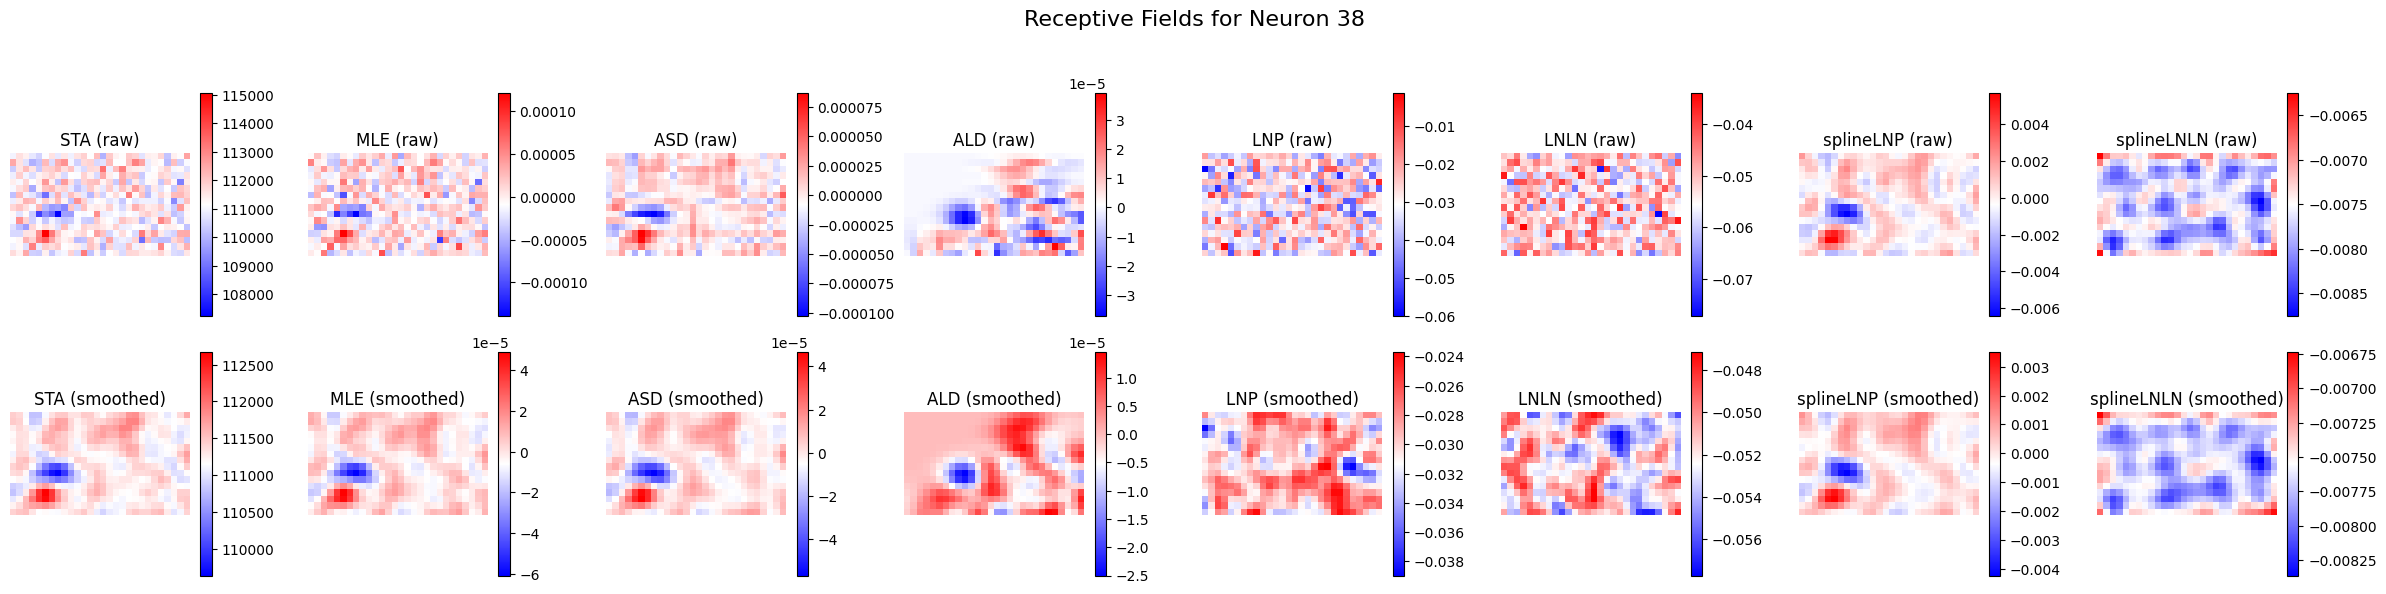

Plotting filters for neuron 60


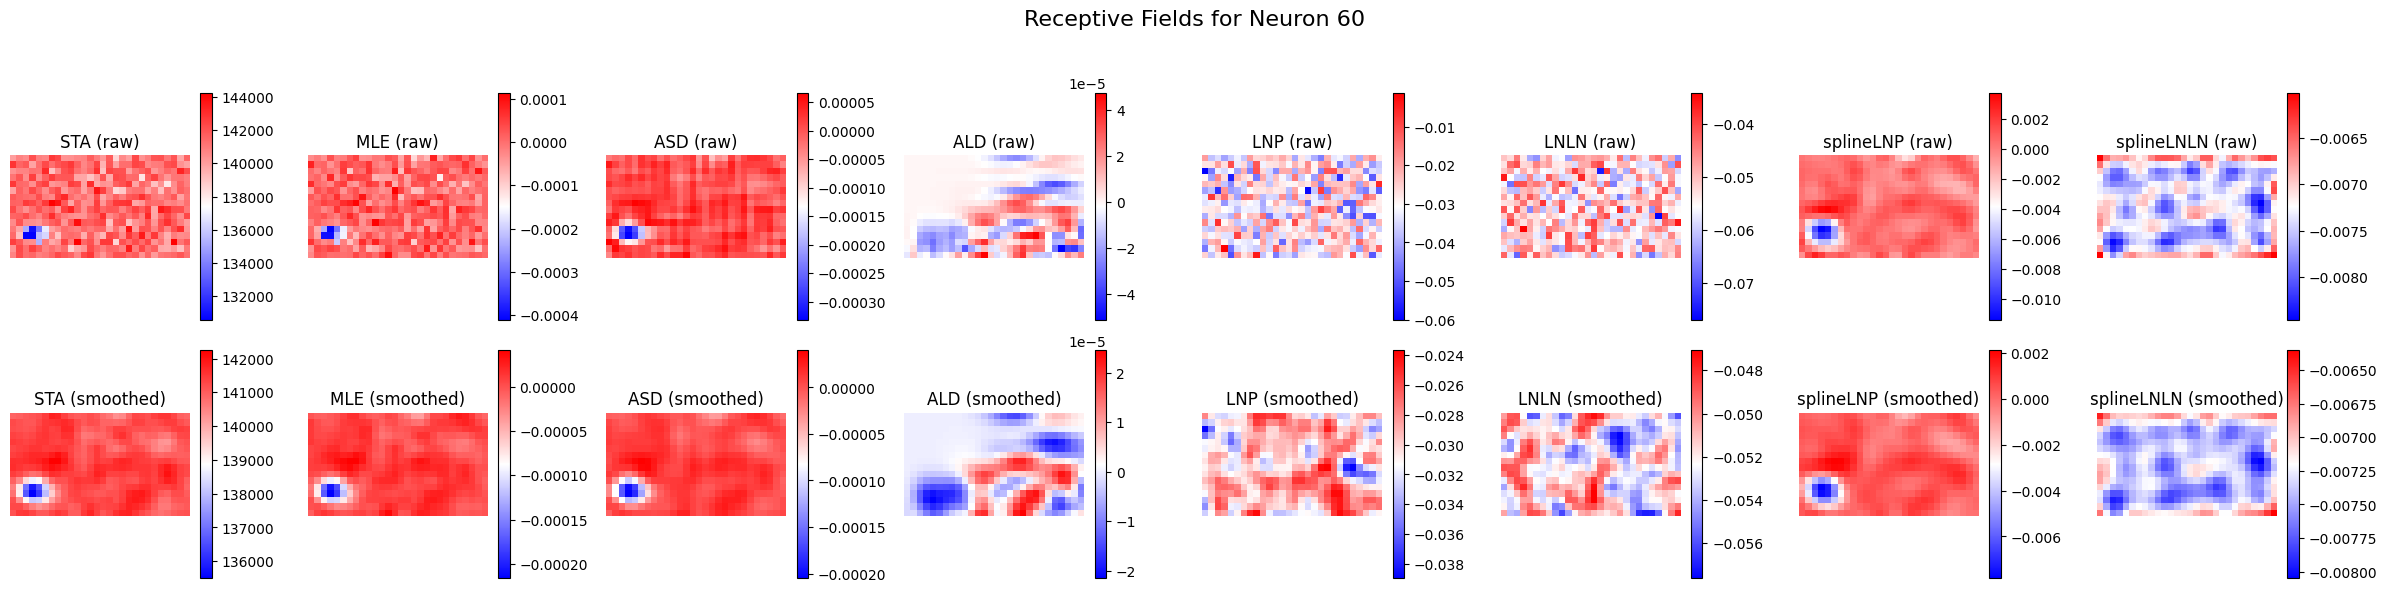

In [96]:
# Plot function

# Full list of methods to visualize
all_methods = ["STA", "MLE", "ASD", "ALD", "LNP", "LNLN", "splineLNP", "splineLNLN"]

for idx in neuron_indices:
    print(f"Plotting filters for neuron {idx}")
    available_methods = [m for m in all_methods if m in filters[idx]]
    n_methods = len(available_methods)

    plt.figure(figsize=(3 * n_methods, 6))

    for i, method in enumerate(available_methods):

        w = filters[idx][method]

        if w.ndim == 2:
            w = np.mean(w, axis=1).reshape(Dx, Dy)
        else:
            w = w.reshape(Dx, Dy)

        # Raw
        plt.subplot(2, n_methods, i + 1)
        plt.imshow(w, cmap="bwr")
        plt.title(f"{method} (raw)")
        plt.axis("off")
        plt.colorbar()

        # Smoothed
        plt.subplot(2, n_methods, i + 1 + n_methods)
        plt.imshow(gaussian_filter(w, sigma=1), cmap="bwr")
        plt.title(f"{method} (smoothed)")
        plt.axis("off")
        plt.colorbar()

    plt.suptitle(f"Receptive Fields for Neuron {idx}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Method comparison analysis

In [ ]:
our_sta = compute_sta_for_neuron(
    spike_trace,
    stims,
    stim_metadata,
    Dx,
    Dy,
    bin_size=bin_size,
    n_lags=n_lags,
)

our_lnp = fit_receptive_field_lnp(binned_spike_counts, stim_binned, lags, dt, R=R)
w_sta = filters[neuron_id]["STA"].flatten()
w_dict = {
    # "our_STA": our_sta[:, 4],  # use last lag
    # "our_LNP": our_lnp[:, 4],  # wrong shape, don't even know (anyways it looks bad)
    "MLE": filters[neuron_id]["MLE"].flatten(),
    "ASD": filters[neuron_id]["ASD"].flatten(),
    "ALD": filters[neuron_id]["ALD"].flatten(),
    "LNP": filters_main[neuron_id]["LNP_opt"].flatten(),
    # "LNLN": filters_main[neuron_id]["LNLN_w_opt"].flatten(),
    "splineLNP": filters_spline[neuron_id]["splineLNP_w_opt"].flatten(),
    # "splineLNLN": filters_spline[neuron_id]["splineLNLN_w_opt"].flatten(),
}

print(our_lnp[:, 4].shape)
print(filters_main[neuron_id]["LNLN_w_opt"].flatten().shape)